Premier laboratoire (labo n°2) de LOG635  
  
Session HIVER 2023  
  
  
**Equipe A :**  
Juneau Bélanger  
Victor St-Louis  
Damien Desvent  

# Sommaire

1. [Pré-traitement des images](#pré-traitement-de-nos-images)
  
2. [Augmentation des données](#augmentation-des-données)
3. [Ajout de primitives](<#primitives>)
4. [Implémenation de notre réseau de neurones](#notre-réseau-de-neurones)
5. [Comparaison de notre réseau de neurones avec plusieurs autres modèles](#comparaison)
    1. [Chargement du dataset](#chargement-et-visualisation-de-notre-jeu-de-données)
    2. [Préparation du dataset](#préparation-du-dataset)
    3. [Modèles d'apprentissage](#modèles-dapprentissage--knn-svm-nn-et-cnn)
        1. [Avec l'ensemble des données](#avec-100-des-données-cest-la-version-la-plus-expliquée-les-autres-étant-des-copies) (c'est la version la plus détaillée)
        2. [Avec 80% des données d'entrainement](#avec-80-des-données)
        3. [Avec 60% des données d'entrainement](#avec-60-des-données)
        4. [Avec 40% des données d'entrainement](#avec-40-des-données)
        5. [Avec 20% des données d'entrainement](#avec-20-de-données)
    4. [Synthèse des résultats des comparaisons](#synthèse-des-résultats)

# Pré-traitement de nos images

Dans cette section, nous réalisons le pré-traitement de nos images. Le but ici est d'extraire la région d'intérêt des images car les images de base formaient beaucoup trop de primitives.  
Nous avons donc extrait de manière automatique la région d'intérêt puis nous avons sauvegardé les images en noir et blanc et redimensionnées en 40x40.  
  
Nous avons choisi de travailler avec le sous-ensemble composé de la totalité des images des ensembles suivants : *Cercle 2, Cercle 5, Diamants 2, Diamants 5, Hexagones 2, Hexagones 5, Triangles 2* et *Triangles 5*.  
  
Les images d'origine n'ont pas été mis dans l'archive afin de sauver de l'espace mais le résultat du pré-traitement est stocké dans le dossier `output`.

***

Le code ci-dessous permet de réaliser un pré-traitement en supposant l'emplacement de la forme dans l'image. L'utilisateur appuie sur la touche Espace si l'emplacement prédit est correct ou sinon il trace lui-même l'emplacement prédit.  
  
Un dossier d'erreur est créé avec les images qui n'ont pas de contour prédits, nous les avons annoté à la main mais nous aurions pu nous contenter des images prédites qui, même si elles peuvent comporter des erreurs, sont plus rapides à nettoyer car elles ont majoritairement un contour correctement prédit.

In [14]:
from pathlib import Path
import sys

# Des constantes qui représentent les différents chemins de dossiers utilisés plus loin
lab_root = str(Path(sys.path[0], '..').resolve()).replace('\\', '/') + '/'
data_dir = lab_root + 'data/'
export_folder =  lab_root + 'output/'
clean_data_folder = export_folder + 'clean/'
error_data_folder = export_folder + 'error/'

In [3]:
import cv2
import os

good_prediction = 0
bad_prediction = 0

for i in os.listdir(data_dir) :
    for j in os.listdir(data_dir + str(i)) :
        index = 0
        for k in os.listdir(data_dir + str(i) + '/' + str(j)) : # on boucle sur toutes les images du jeu de données
            if not os.path.isfile(clean_data_folder + str(i) + '/' + str(j) + '/' + str(k)): 
                index += 1
                if index < 10000 :
                    image = cv2.imread(data_dir + str(i) + '/' + str(j) + '/' + str(k))
                    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # on passe l'image en niveau de gris
                    img_blur = cv2.GaussianBlur(img_gray, (9,9), 0) # flou pour aider à la distinction des contours
                    edged = cv2.Canny(img_blur, 30,120) # Canny fonctionne comme un double threshold

                    # on cherche des contours sur les images
                    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    img_output = img_gray
                    img_view = image.copy()

                    x,y,w,h = 0,0,0,0

                    # on trace les contours qui ont une aire acceptable
                    for c in contours :
                        area = cv2.contourArea(c)
                        if area > 400 :
                            x,y,w,h = cv2.boundingRect(c)
                            cv2.rectangle(img_view, (x, y), (x + w, y + h), (36, 255, 12), 2) #crée une bbox verte

                    os.makedirs(clean_data_folder + str(i) + '/' + str(j) + '/', exist_ok=True)
                    os.makedirs(error_data_folder + str(i) + '/' + str(j) + '/', exist_ok=True)

                    print(str(k))
                    rect = cv2.selectROI(img=img_view, windowName=str(k))
                    cv2.destroyAllWindows()
                    if rect == (0,0,0,0) :
                        img_output = image[y:y+h,x:x+w]
                        
                    else :
                        img_output = image[int(rect[1]):int(rect[1]+rect[3]), int(rect[0]):int(rect[0]+rect[2])]

                    # on redimensionne les images en 40x40 pour que la détection soit plus efficace
                    img_output = cv2.resize(img_output,dsize=(40,40), interpolation=cv2.INTER_AREA)
                    cv2.imwrite(clean_data_folder + str(i) + '/' + str(j) + '/' + str(k), img_output)
                    good_prediction += 1

146_Diamant2.jpg


# Augmentation des données

Dans cette section, on augmente artificiellement les données afin de multiplier la taille du dataset sans avoir besoin de nouvelles images.

Pour augmenter le nombre d'images, on génère des variations de chaque image en lui appliquant des transformations telles que la réflexion et la rotation. Nous avons créé une fonction qui va générer 8 images transformées pour une seule image initiale, cette fonction sera utilisée lors de l'ingestion de notre ensemble de données :

In [3]:
import cv2

# returns 8 images
def get_variations(image):
    return (
        image, # image d'origine
        cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), # image à 90°
        cv2.rotate(image, cv2.ROTATE_180), # image à 180°
        cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), # image à -90°
        cv2.flip(image, 0), # image en miroir
        cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_90_CLOCKWISE), # image en miroir à 90°
        cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_180), # image en miroir à 180°
        cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_90_COUNTERCLOCKWISE), # image en miroir à -90°
    )

La première étape de l'ingestion des données est de lister les fichiers présents dans notre dossier de données :

In [4]:
from glob import glob

def files_list(root):
    return glob(root + '/**/*.jpg', recursive=True)

On définit égalemement des fonctions utilitaires qui nous seront utiles lors de la séparation des données

In [5]:
from os.path import basename, dirname

def one_hot_encode(category, categories):
    category_index = categories.index(category)
    y_vector = np.zeros(8)
    y_vector[category_index] = 1
    return y_vector

# Transforme les fichiers en images cv2 en augmentant le nombre d'images
def addlabel_augment(files):
    for filepath in files:
        label = basename(dirname(filepath))
        image = np.float32(cv2.cvtColor(cv2.imdecode(np.fromfile(filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2GRAY)) / 255
        for v in get_variations(image):
            yield (label, v)

# Transforme les fichiers en images cv2 sans augmenter le nombre d'images
def addlabel(files):
    for filepath in files:
        label = basename(dirname(filepath))
        image = np.float32(cv2.cvtColor(cv2.imdecode(np.fromfile(filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2GRAY)) / 255
        yield (label, image)

# Ce générateur permet de fournir un accès dans le désordre à la liste de fichiers, et ce de facon `lazy`
def randomize(list, seed):
    generator = np.random.default_rng(seed)
    length = len(list)
    permutation = generator.permutation(length)
    for i in permutation:
        yield list[i]

Finalement, on définit une fonction qui nous permettera d'obtenir le npmbre d'exemples dans chaque classe :

In [6]:
def count_each_shape(files, categories):
    names = list(map(lambda f: basename(dirname(f)), files))
    return list(map(lambda category: (category, names.count(category)), categories))

Enfin, on peut définir la fonction qui fera l'ingestion et la séparation des données à partir du chemin d'accès du dossier d'images

In [7]:
from itertools import accumulate

def split_dataset(data_root, categories, sets_proportions, augmented=False):
    # Le paramètre `augmented` permet de décider si on veut la version augmentée des données
    augmentation_factor = 8 if augmented else 1 
    files_to_labels = addlabel_augment if augmented else addlabel
    
    # sets_proportions est un array de nombres qui représentent la proportion de chaque sous-ensemble de données
    files = files_list(data_root)
    factor = len(files) * augmentation_factor / sum(sets_proportions)
    sets_sizes = list(map(lambda p : round(p * factor), sets_proportions))
    sets = []
    for s in sets_sizes:
        sets.append((
            [], # X
            [] # y
        ))
    # La préparation des ensembles est terminée, on peut maintenant les remplir

    # On affiche le nombre de fichiers dans chaque classe
    print(count_each_shape(files, categories))
    # On accède aux fichiers dans le désordre pour éviter de placer toutes les images d'une même classe dans le même ensemble
    for (i, (label, image)) in enumerate(randomize(list(files_to_labels(files)), 305)):
        # On trouve le prochain ensemble qui n'est pas plein
        set = sets[list(map(lambda tot_size : i < tot_size, accumulate(sets_sizes))).index(True)]
        
        # On encode la classe sous forme de `one-hot-encoding`
        y_vector = one_hot_encode(label, categories)
        set[0].append(image.reshape(-1)) # X
        set[1].append(y_vector) # y
    return map(lambda s : (np.array(s[0]), np.array(s[1])), sets)

Si on désire plutôt pré-générer les images augmentées, on peut utiliser cette fonction :

In [ ]:
import os

data_dir = lab_root + 'output/clean/'
augmented_data_dir = lab_root + 'output/augmented/'

# returns 8 tuples (name_suffix, image)
def generate_variations(image):
    return (
        ('', image),
        ('_90', cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)),
        ('_180', cv2.rotate(image, cv2.ROTATE_180)),
        ('_270', cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)),
        ('_flip', cv2.flip(image, 0)),
        ('_flip_90', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_90_CLOCKWISE)),
        ('_flip_180', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_180)),
        ('_flip_270', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_90_COUNTERCLOCKWISE)),
    )

indice = 0
for i in os.listdir(data_dir) :
    for j in os.listdir(data_dir + str(i)) :
        for k in os.listdir(data_dir + str(i) + '/' + str(j)) :
            if not os.path.isfile(augmented_data_dir + str(i) + '/' + str(j) + '/' + str(k)) :
                indice += 1
                image = cv2.imread(data_dir + str(i) + '/' + str(j) + '/' + str(k))
                img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
                
                os.makedirs(augmented_data_dir + str(i) + '/' + str(j) + '/', exist_ok=True)

                for (sufix,img_output) in generate_variations(img_blur) :
                    cv2.imwrite(augmented_data_dir + str(i) + '/' + str(j) + '/' + str(k).split('.')[0] + sufix + '.jpg', img_output)
                    
print('{} images augmentées'.format(indice))

2439 images augmentées


# Primitives

Dans cette section, on implémente des nouvelles primitives en plus des primitives des pixels.  
Cet ajout de primitives permet d'ajouter des données au modèle sans avoir besoin d'ajouter des images au dataset.  
  
Nous pourrons ainsi améliorer l'exactitude de notre modèle.

Pour l'extraction des primitives, nous avons utiliser "skimage" avec les "region properties". Par contre, cette technique d'extraction nous permet d'avoir plus de cinquantes primitives sur chaque image. En créant un matrice de corrélation entre les différentes primitives, nous avons réussi à chosir celles qui sont le plus probables d'être utile pour la classification d'une image. L'évaluation des primitives a été réalisée avec le code suivant. Il permet d'afficher la matrice de corrélation entre deux types d'image (dans cette exemple, *Cercle2* et *Cercle5*). Le choix de ces types peut facilement être changer avec le "path". Aussi, il est possible d'afficher les différents graphiques entre deux primitives pour évaluer l'extranticité des résultats.

Cercle2
Cercle5


<Figure size 640x480 with 0 Axes>

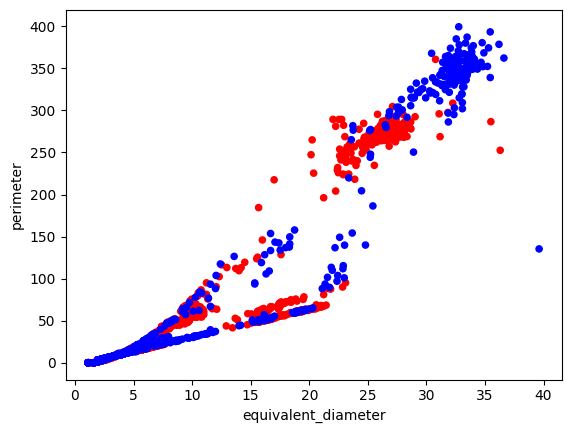

<Figure size 640x480 with 0 Axes>

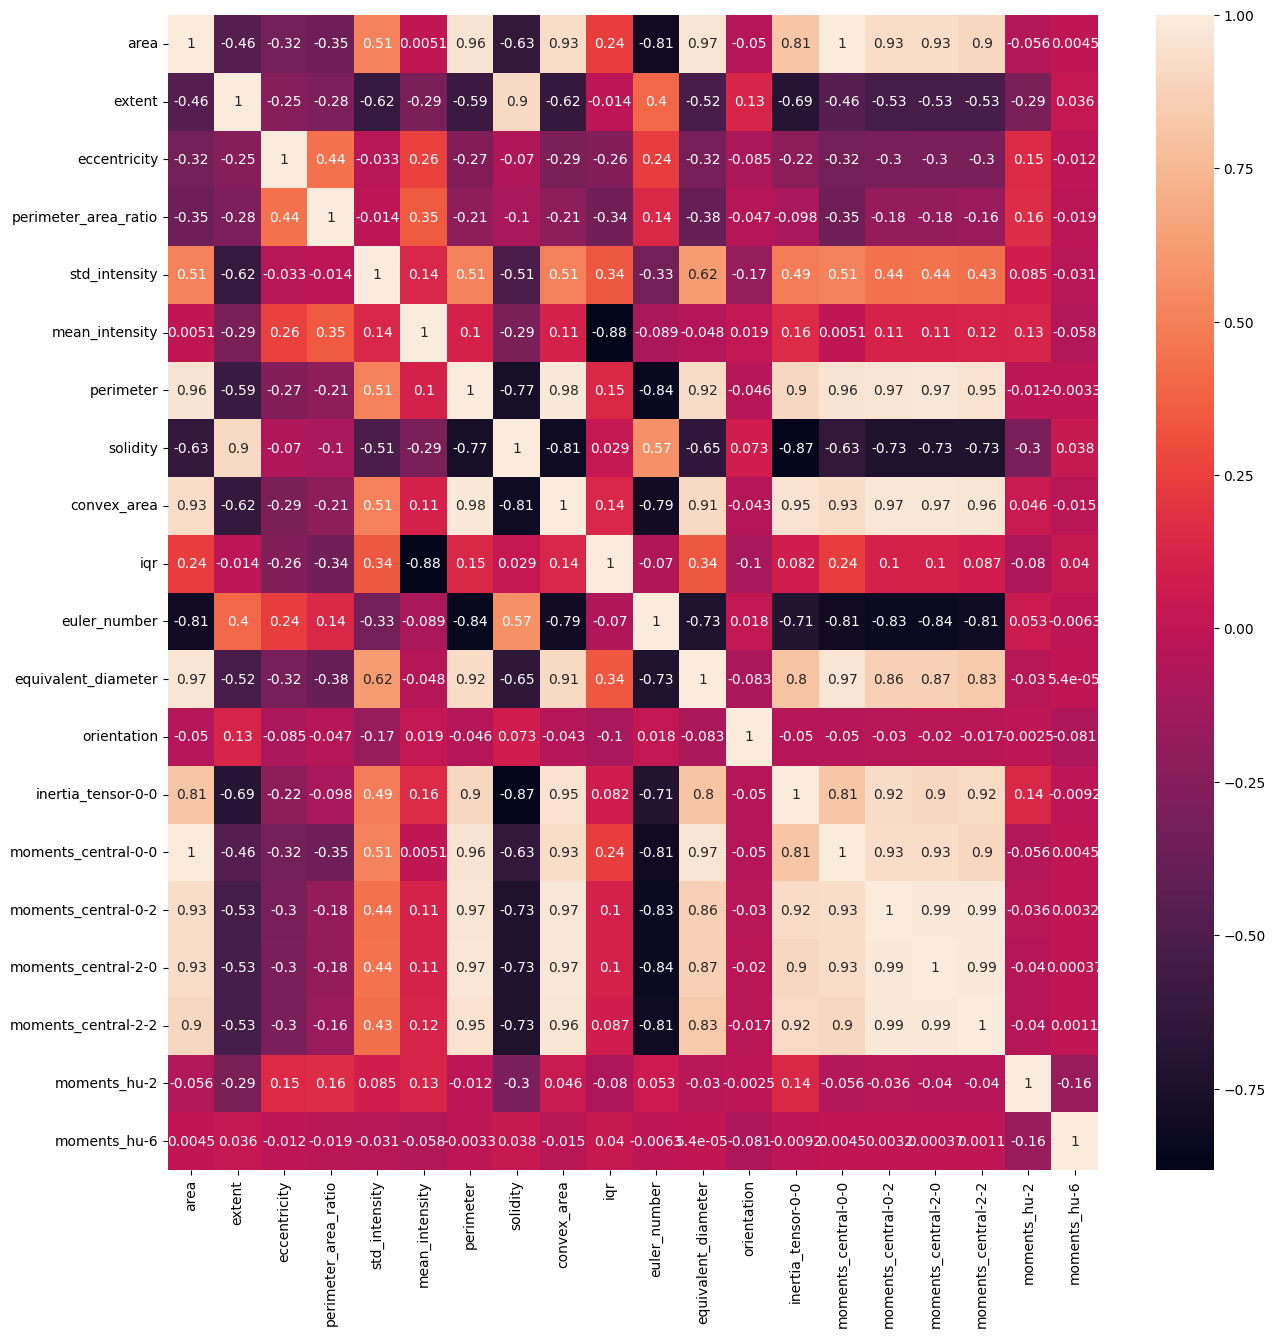

In [8]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import closing
from skimage.measure import label, regionprops, regionprops_table
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
from IPython.display import display
import seaborn as sn

#pip install scikit-image
#pip install -U scikit-learn scipy matplotlib
#pip install pandas
#pip install tqdm
#pip install ipython
#pip install seaborn
#https://mattmaulion.medium.com/leaf-classification-an-image-processing-feature-extraction-approach-to-machine-learning-c0677e07da80

image_path_list = os.listdir("../output/clean/Cercles") #permet de faire la comparaison entre les différents images par type (cercle2,cercle5)
dataframe = pd.DataFrame()
colors = {'Cercle2':'red', 'Cercle5':'blue'} #détermine les couleurs pour les graphiques par types
for k in (image_path_list):
  image_list = os.listdir("../output/clean/Cercles/"+str(k))
  print(k) #print le type de l'image en cours
  for i in  range(len(image_list)):
    image_path = image_list[i]
    image = rgb2gray(imread("../output/clean/Cercles/"+k+"/"+image_path)) #applique le grayscale à l'image en cours
    binary = image < threshold_otsu(image) #applique le treshold à l'image en cours
    binary = closing(binary) 
    label_img = label(binary) #label appliquer sur l'image
    
    #crée la table du dataframe avec les différentes primitives (une par colonne)
    table = pd.DataFrame(regionprops_table(label_img, image,
                            ['convex_area', 'area', 'eccentricity',
                            'extent', 'inertia_tensor',                         
                            'major_axis_length', 'minor_axis_length',
                            'perimeter', 'solidity', 'image',
                            'orientation', 'moments_central',
                            'moments_hu', 'euler_number',
                            'equivalent_diameter',
                            'mean_intensity', 'bbox']))
    table['perimeter_area_ratio'] = table['perimeter']/table['area']
    real_images = []
    std = []
    mean = []
    percent25 = []
    percent75 = []
    for prop in regionprops(label_img): 
        min_row, min_col, max_row, max_col = prop.bbox
        img = image[min_row:max_row,min_col:max_col]
        real_images += [img]
        mean += [np.mean(img)]
        std += [np.std(img)]
        percent25 += [np.percentile(img, 25)] 
        percent75 += [np.percentile(img, 75)]
    table['real_images'] = real_images
    table['mean_intensity'] = mean
    table['std_intensity'] = std
    table['25th Percentile'] = mean
    table['75th Percentile'] = std
    table['iqr'] = table['75th Percentile'] - table['25th Percentile']
    table['label'] = k
    dataframe = pd.concat([dataframe, table], axis=0)
  
dataframe.head()

#sélection des primitives importantes
X = dataframe[['area','extent', 'eccentricity','perimeter_area_ratio','std_intensity', 'mean_intensity','perimeter', 'solidity', 'convex_area', 
        'iqr', 'euler_number', 'equivalent_diameter', 'orientation','inertia_tensor-0-0','moments_central-0-0','moments_central-0-2',
        'moments_central-2-0','moments_central-2-2','moments_hu-2','moments_hu-6']]

plt.figure("graph scatter")

#affiche un graphique de type scatter pour les images sur les colonnes choisi en paramètres
X.plot.scatter(x='equivalent_diameter',y='perimeter',c= dataframe['label'].map(colors))

corr_matrix = X.corr() 
plt.figure("matrice corrélation")
plt.subplots(figsize=(15,15))
#création de la matrice de corrélation entre les différentes primitives
sn.heatmap(corr_matrix, annot=True)

#affichage des figures
plt.show()

Lors de la première génération du code, nous avons inclus toutes les primtives et en observant la matrice de corrélation, nous avons éliminé les primivites qui avaient le moins d'impact sur les autres. En d'autres mots, nous avons gardé les primitives qui corrélaient le mieux (qui avaient des valeurs qui se rapprochaient le plus de 1 et -1). Des observations ont été fait avec plusieurs exemples de type d'image et non seulement *Cercle2* et *Cercle5*.

En observant le graphique, on peut clairement voir deux groupes région distincts. Nous indiquant que les primitives testées pour cet exemple, equivalent_diameter et perimiter, nous permette de bien différencier les formes dans les images fournies.

***

Pour le réseau de neurones, le code démontré au dessus a été adapté en une fonction qui prends en entrée une image seulement et retourne les primitives des régions analysées. Les graphiques et matrice de corrélation ont aussi été retirés, car ils n'ont plus d'utilité dans cette section.

In [9]:
%pip install scikit-image

from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import closing
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import numpy as np

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
def solo_features(image):
    df = pd.DataFrame()
    image = imread(image)
    if len(image.shape) == 3 : image = rgb2gray(imread(image)) #applique le grayscale à l'image en cours
    binary = image < threshold_otsu(image) #applique le treshold à l'image en cours
    binary = closing(binary)
    label_img = label(binary) #label appliquer sur l'image

    table = pd.DataFrame(regionprops_table(label_img, image,
                            ['convex_area', 'area', 'eccentricity',
                            'extent', 'inertia_tensor',                         
                            'major_axis_length', 'minor_axis_length',
                            'perimeter', 'solidity', 'image',
                            'orientation', 'moments_central',
                            'moments_hu', 'euler_number',
                            'equivalent_diameter',
                            'mean_intensity', 'bbox']))
    #crée la table du dataframe avec les différentes primitives (une par colonne)
    table['perimeter_area_ratio'] = table['perimeter']/table['area']
    real_images = []
    std = []
    mean = []
    percent25 = []
    percent75 = []

    for prop in regionprops(label_img): 
        min_row, min_col, max_row, max_col = prop.bbox
        img = image[min_row:max_row,min_col:max_col]
        real_images += [img]
        mean += [np.mean(img)]
        std += [np.std(img)]
        percent25 += [np.percentile(img, 25)] 
        percent75 += [np.percentile(img, 75)]

    table['real_images'] = real_images
    table['mean_intensity'] = mean
    table['std_intensity'] = std
    table['25th Percentile'] = mean
    table['75th Percentile'] = std
    table['iqr'] = table['75th Percentile'] - table['25th Percentile']
    table['label'] = 'img'
    df = pd.concat([df, table], axis=0)
    df.head()

    #sélection des primitives importantes
    X = df[['area','extent', 'eccentricity','perimeter_area_ratio','std_intensity', 'mean_intensity','perimeter', 'solidity', 'convex_area', 'iqr', 'euler_number', 'equivalent_diameter', 'orientation','inertia_tensor-0-0',
            'moments_central-0-0','moments_central-0-2','moments_central-2-0','moments_central-2-2','moments_hu-2','moments_hu-6']]

    #Moyenne des primites pour les régions trouvées et le calcul pour le nombre de région trouvée
    count = len(X.index)
    features = X.mean().to_dict()
    features['nb_contours'] = count
    
    return features

On peut voir un exemple du calcul des primitives pour une image :

In [11]:
solo_features('../output/augmented/Cercles/Cercle5/1_Cercle5_90.jpg')

{'area': 286.0,
 'extent': 0.52125,
 'eccentricity': 0.6378512682874985,
 'perimeter_area_ratio': 0.7124159977970757,
 'std_intensity': 48.53417283165064,
 'mean_intensity': 90.42104166666667,
 'perimeter': 131.43418707023054,
 'solidity': 0.7589981242414212,
 'convex_area': 546.6666666666666,
 'iqr': -41.88686883501602,
 'euler_number': 0.6666666666666666,
 'equivalent_diameter': 14.079342887286481,
 'orientation': 0.5696239780215264,
 'inertia_tensor-0-0': 51.77252316411978,
 'moments_central-0-0': 286.0,
 'moments_central-0-2': 40706.43078827783,
 'moments_central-2-0': 42907.69670835736,
 'moments_central-2-2': 6243252.918054325,
 'moments_hu-2': 0.0002487461667192578,
 'moments_hu-6': -3.7638095293295405e-08,
 'nb_contours': 3}

Les primitives peuvent être ajoutées à chaque exemple de données. Pour ce faire il faut modifier le code qui crée le réseau de neurones comme suit :

In [ ]:
features = map(solo_features, files)

nn = NeuralNetwork(
  nb_input_nodes=40*40 + len(features),
  nb_hidden_nodes=100,
  nb_output_nodes=8,
  learning_rate=0.001,
  epochs=120
)

Malheureusement, le temps requis pour refaire tout le processus d'optimisation des hyperparamètres, nous a empêché d'intégrer ces primitives à notre modèle final. C'est l'implémentation du réseau neuronal sans primitive qui est présenté à la section suivante.

***

# Notre réseau de neurones

Dans cette section, on implémente notre propre réseau de neurones.  
On crée donc des classes et fonctions afin que notre réseau de neurones puisse être le plus efficace possible.  
On réfléchit également au choix des hyper-paramètres.

Voici le code de la classe `NeuralNetwork` qui contient plusieurs méthodes qui vont servir à entrainer le modèle et à obtenir des prédictions et des informations sur l'entrainement

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Les paramètres du réseau de neurones sont : le nombre de noeuds en entrée, le nombre de noeuds cachés, le nombre de noeuds en sortie,
# le taux d'apprentissage et le nombre d'itérations d'entrainement.
class NeuralNetwork():
    def __init__(self, nb_input_nodes, nb_hidden_nodes, nb_output_nodes, learning_rate, epochs):
        self.nb_input_nodes = nb_input_nodes
        self.nb_output_nodes = nb_output_nodes
        self.nb_hidden_nodes = nb_hidden_nodes
        self.learning_rate = learning_rate
        self.epochs = epochs

        # On initialise des tableaux vides pour stocker les données de coût
        self.losses_train = []
        self.losses_valid = []

        # Poids de la couche d'entrée à la couche cachée
        self.W1 = np.random.randn(self.nb_input_nodes, self.nb_hidden_nodes)
        # Biais de la couche d'entrée à la couche cachée
        self.b1 = np.random.randn(1, self.nb_hidden_nodes)

        # Poids de la couche cachée à la couche de sortie
        self.W2 = np.random.randn(self.nb_hidden_nodes, self.nb_output_nodes)
        # Biais de la couche cachée à la couche de sortie
        self.b2 = np.random.randn(1, self.nb_output_nodes)

    # Définition de la fonction sigmoide
    def sigmoid(self, z):
        s = 1 / (1 + np.exp(-z))
        return s

    # Définition de la fonction de coût entropie croisée
    def entropy_loss(self, y, y_pred):
        N = y.shape[0]
        eps = np.finfo(float).eps
        y_pred = np.maximum(y_pred, eps)
        y_pred = np.minimum(y_pred, 1 - eps)
        loss = -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / (N * self.nb_output_nodes)
        return loss
    
    # Méthode qui effectue la propagation avant
    def forward(self, X):
        self.X = X
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    # Méthode qui effectue la propagation arrière
    def backward(self, y):
        
        # Voici des sources qui nous ont aidées à mieux comprendre l'implémentation de la propagation arrière
        # https://www.youtube.com/watch?v=tIeHLnjs5U8 Backpropagation calculus
        # https://www.youtube.com/watch?v=x4RNPJD-IkQ Backpropagation: Compute the Derivatives - Part 1
        # https://www.youtube.com/watch?v=JsbFBJCWbeI Backpropagation: Compute the Derivatives - Part 2
        # https://www.youtube.com/watch?v=55nIWdjgOJU Code a NN from Scratch

        N = y.shape[0]
        dL_dZ2 = (self.A2 - y)
        dL_dW2 = self.A1.T @ dL_dZ2
        ones = np.ones((N, 1))
        dL_db2 = ones.T @ dL_dZ2
        delta1 = dL_dZ2 @ self.W2.T
        dsig = self.sigmoid(self.A1) * (1 - self.sigmoid(self.A1))
        dL_dW1 = self.X.T @ (delta1 * dsig)
        dL_db1 = ones.T @ (delta1 * dsig)

        # Mise à jour des poids et des biais
        self.W2 = self.W2 - self.learning_rate * dL_dW2
        self.b2 = self.b2 - self.learning_rate * dL_db2
        self.W1 = self.W1 - self.learning_rate * dL_dW1
        self.b1 = self.b1 - self.learning_rate * dL_db1

    # Méthode servant à entrainer le réseau de neurones
    def train(self, Xtrain, ytrain, Xvalid, yvalid):
        for i in range(self.epochs):
            # On commence par prendre le coût de l'ensemble de validation
            yvalid_pred = self.forward(Xvalid)
            loss_valid = self.entropy_loss(yvalid, yvalid_pred)
            self.losses_valid.append(loss_valid)
            # On prends ensuite le coût de l'ensemble d'entrainement
            ytrain_pred = self.forward(Xtrain)
            loss_train = self.entropy_loss(ytrain, ytrain_pred)
            self.losses_train.append(loss_train)
            # Finalement, on effectue la propagation arrière
            self.backward(ytrain)

    # Méthode servant à obtenir une prédiction pour un ensemble de données en entrée
    def predict(self, X):
        return np.round(self.forward(X))

    # Méthode servant à produire un graphique du coût des ensembles de validation et d'entrainement au long des itérations
    def plot_loss(self):
        plt.plot(self.losses_train, label='losses train')
        plt.plot(self.losses_valid, label='losses validation')
        plt.xlabel("Iteration")
        plt.ylabel("loss")
        plt.title("Loss curve for training")
        plt.show()


Voici notre fichier `main.py` dans lequel nous utilisons la classe `NeuralNetwork`.

[('Cercle2', 317), ('Cercle5', 215), ('Diamant2', 440), ('Diamant5', 200), ('Hexagone2', 351), ('Hexagone5', 293), ('Triangle2', 464), ('Triangle5', 159)]
Shape of Xtrain is (1951, 1600)
Shape of ytrain is (1951, 8)
Shape of Xvalid is (244, 1600)
Shape of yvalid is (244, 8)
Shape of Xtest is (244, 1600)
Shape of ytest is (244, 8)


C:\Users\damie\AppData\Local\Temp\ipykernel_13148\2385933932.py:30: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-z))
C:\Users\damie\AppData\Local\Temp\ipykernel_13148\2385933932.py:30: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-z))


Accuracy of test set : 0.5655737704918032
Accuracy of validation set : 0.5491803278688525


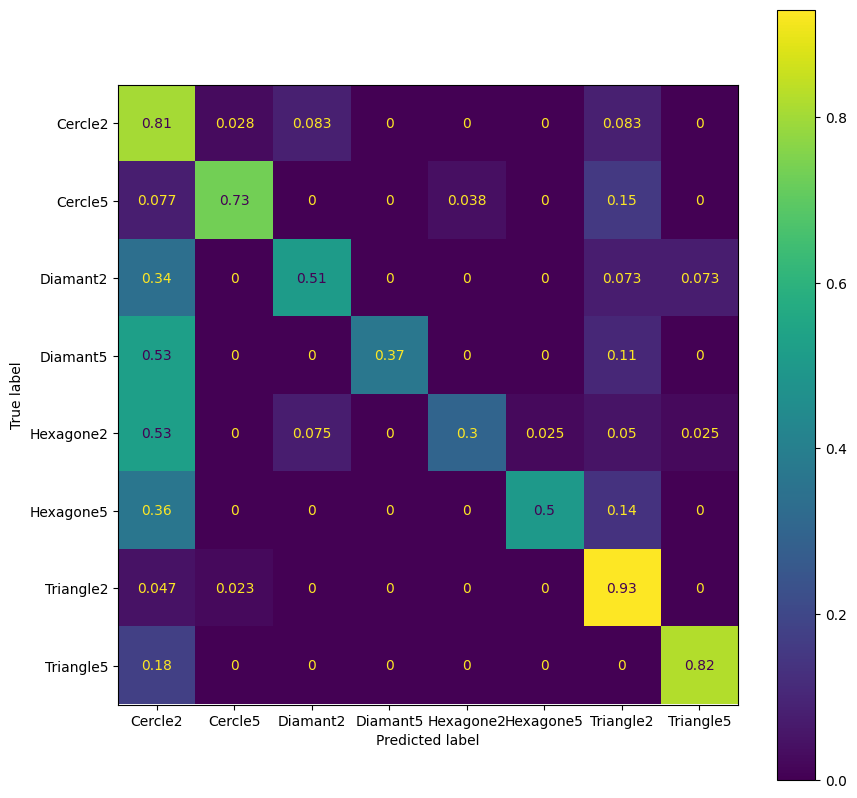

Accuracy: 0.565574 

Precision: 0.885764 

Recall: 0.541256 

F1 score: 0.636878 



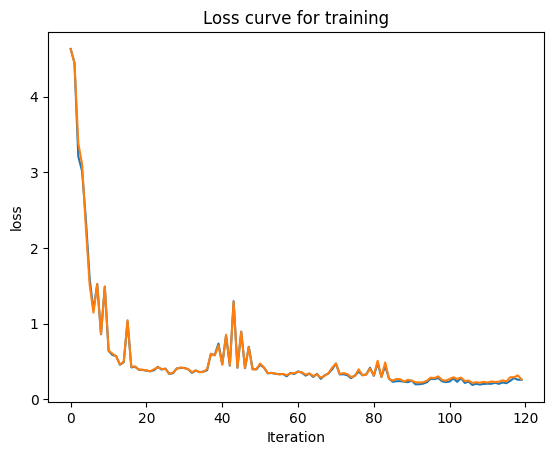

In [174]:
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import os
import time

# Voici les noms des classes qui constitueront la sortie de notre modèle
categories = [
  'Cercle2',
  'Cercle5',
  'Diamant2',
  'Diamant5',
  'Hexagone2',
  'Hexagone5',
  'Triangle2',
  'Triangle5',
]

# La fonction split_dataset s'occupe de séparer nos exemples d'image en 3 ensembles, un d'entrainement, un de validation et un de test
# On choisit ici de ne pas augmenter les données
[[Xtrain, ytrain], [Xvalid, yvalid], [Xtest, ytest]] = split_dataset(clean_data_folder, categories, [8, 1, 1], augmented=False)

# On s'assure de que la forme de chaque ensemble est celle qui est attendue 
print(f"Shape of Xtrain is {Xtrain.shape}")
print(f"Shape of ytrain is {ytrain.shape}")
print(f"Shape of Xvalid is {Xvalid.shape}")
print(f"Shape of yvalid is {yvalid.shape}")
print(f"Shape of Xtest is {Xtest.shape}")
print(f"Shape of ytest is {ytest.shape}")

# Création du réseau
nn = NeuralNetwork(
  nb_input_nodes=40*40,
  nb_hidden_nodes=100,
  nb_output_nodes=8,
  learning_rate=0.001,
  epochs=120
)

# Entrainement du réseau
train_start = time.time()
nn.train(Xtrain, ytrain, Xvalid, yvalid)
train_end = time.time()
training_time_my_nn = train_end - train_start

# On calcule l'accuracy du modèle en utilisant l'ensemble de test
test_start = time.time()
ytest_pred = nn.predict(Xtest)
test_end = time.time()
testing_time_my_nn = test_end - test_start

accuracy_test = accuracy_score(ytest, ytest_pred)

yvalid_pred = nn.predict(Xvalid)
accuracy_valid = accuracy_score(yvalid, yvalid_pred)

print(f'Accuracy of test set : {accuracy_test}')
print(f'Accuracy of validation set : {accuracy_valid}')

# On calcule la matrice de confusion du modèle en utilisant l'ensemble de test
cf_matrix = confusion_matrix(yvalid.argmax(axis=1), yvalid_pred.argmax(axis=1), normalize='true')
cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)
plt.show()

y_test = ytest
y_pred_my_nn = ytest_pred
# accuracy: (tp + tn) / (fp + fn)
accuracy_my_nn = accuracy_test
print('Accuracy: %f' % accuracy_my_nn, '\n')
# precision tp / (tp + fp)
precision_my_nn = precision_score(y_test, y_pred_my_nn, average='macro', zero_division=0)
print('Precision: %f' % precision_my_nn, '\n')
# recall: tp / (tp + fn)
recall_my_nn = recall_score(y_test, y_pred_my_nn, average='macro', zero_division=0)
print('Recall: %f' % recall_my_nn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_my_nn = f1_score(y_test, y_pred_my_nn, average='macro', zero_division=0)
print('F1 score: %f' % f1_my_nn, '\n')

# On affiche un graphique de la courbe de coût au long de l'entrainement
nn.plot_loss()

On remarque une forte baisse de la loss durant les premières epochs mais la baisse se poursuit néammoins jusqu'à l'epoch 100 environ.  
On a tracé deux courbes : la loss d'entrainement et de validation. Ici les deux courbes sont tellement simillaires qu'on a du mal à les discerner.  
  
La matrice de corrélation est églament intéressante à observer. On remarque qu'une proportion correcte d'éléments est correctement prédite mais qu'une classe est toujours plus souvent prédite que les 7 autres. Ce biais s'explique sans doute par le fonctionnement du réseau de neurones avec un noeud qui doit influer cette décision précise.

## Choix des hyperparamètres

Nous avons utilisé une simple boucle pour tester le modèle avec différents hyperparamètres et avons choisi ceux qui donnaient la meilleure précision sur l'ensemble de validation.

In [164]:
for i in range(30, 9, -1):
  for j in [0.0008, 0.0009, 0.001, 0.0011, 0.0012]:

    nn = NeuralNetwork(
      nb_input_nodes=40*40,
      nb_hidden_nodes=i,
      nb_output_nodes=8,
      learning_rate=j,
      epochs=120
    )

    ...

nn_80 = NeuralNetwork(
  nb_input_nodes=40*40,
  nb_hidden_nodes=100,
  nb_output_nodes=8,
  learning_rate=0.001,
  epochs=120
)

nn_60 = NeuralNetwork(
  nb_input_nodes=40*40,
  nb_hidden_nodes=100,
  nb_output_nodes=8,
  learning_rate=0.001,
  epochs=120
)

nn_40 = NeuralNetwork(
  nb_input_nodes=40*40,
  nb_hidden_nodes=100,
  nb_output_nodes=8,
  learning_rate=0.001,
  epochs=120
)

nn_20 = NeuralNetwork(
  nb_input_nodes=40*40,
  nb_hidden_nodes=100,
  nb_output_nodes=8,
  learning_rate=0.001,
  epochs=120
)
    

Dans l'optique de tester la scalabilité de notre modèle, on prend des statistiques avec un ensemble de données plus petit de 80%, 60%, 40%, 20%

In [172]:
import math
def limit_set(lst, factor):
    len_list = lst.shape[0]
    return lst[:math.floor(factor * len_list)]

# 80 %
start = time.time()
nn_80.train(limit_set(Xtrain, .8), limit_set(ytrain, .8), limit_set(Xvalid, .8), limit_set(yvalid, .8))
training_time_my_nn_80 = time.time() - start

# Predict
start = time.time()
y_pred_my_nn_80 = nn_80.predict(Xtest)
testing_time_my_nn_80 = time.time() - start
print('Pour 80% des données :')
# accuracy: (tp + tn) / (fp + fn)
accuracy_my_nn_80 = accuracy_score(ytest, y_pred_my_nn_80)
print('Accuracy: %f' % accuracy_my_nn_80, '\n')
# precision tp / (tp + fp)
precision_my_nn_80 = precision_score(y_test, y_pred_my_nn_80, average='macro', zero_division=0)
print('Precision: %f' % precision_my_nn_80, '\n')
# recall: tp / (tp + fn)
recall_my_nn_80 = recall_score(y_test, y_pred_my_nn_80, average='macro', zero_division=0)
print('Recall: %f' % recall_my_nn_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_my_nn_80 = f1_score(y_test, y_pred_my_nn_80, average='macro', zero_division=0)
print('F1 score: %f' % f1_my_nn_80, '\n')


# 60 %
start = time.time()
nn_60.train(limit_set(Xtrain, .6), limit_set(ytrain, .6), limit_set(Xvalid, .6), limit_set(yvalid, .6))
training_time_my_nn_60 = time.time() - start

# Predict
start = time.time()
y_pred_my_nn_60 = nn_60.predict(Xtest)
testing_time_my_nn_60 = time.time() - start
print('Pour 60% des données :')
# accuracy: (tp + tn) / (fp + fn)
accuracy_my_nn_60 = accuracy_score(ytest, y_pred_my_nn_60)
print('Accuracy: %f' % accuracy_my_nn_60, '\n')
# precision tp / (tp + fp)
precision_my_nn_60 = precision_score(y_test, y_pred_my_nn_60, average='macro', zero_division=0)
print('Precision: %f' % precision_my_nn_60, '\n')
# recall: tp / (tp + fn)
recall_my_nn_60 = recall_score(y_test, y_pred_my_nn_60, average='macro', zero_division=0)
print('Recall: %f' % recall_my_nn_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_my_nn_60 = f1_score(y_test, y_pred_my_nn_60, average='macro', zero_division=0)
print('F1 score: %f' % f1_my_nn_60, '\n')


# 40 %
start = time.time()
nn_40.train(limit_set(Xtrain, .4), limit_set(ytrain, .4), limit_set(Xvalid, .4), limit_set(yvalid, .4))
training_time_my_nn_40 = time.time() - start

# Predict
start = time.time()
y_pred_my_nn_40 = nn_40.predict(Xtest)
testing_time_my_nn_40 = time.time() - start
print('Pour 40% des données :')
# accuracy: (tp + tn) / (fp + fn)
accuracy_my_nn_40 = accuracy_score(ytest, y_pred_my_nn_40)
print('Accuracy: %f' % accuracy_my_nn_40, '\n')
# precision tp / (tp + fp)
precision_my_nn_40 = precision_score(y_test, y_pred_my_nn_40, average='macro', zero_division=0)
print('Precision: %f' % precision_my_nn_40, '\n')
# recall: tp / (tp + fn)
recall_my_nn_40 = recall_score(y_test, y_pred_my_nn_40, average='macro', zero_division=0)
print('Recall: %f' % recall_my_nn_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_my_nn_40 = f1_score(y_test, y_pred_my_nn_40, average='macro', zero_division=0)
print('F1 score: %f' % f1_my_nn_40, '\n')


# 20 %
start = time.time()
nn_20.train(limit_set(Xtrain, .2), limit_set(ytrain, .2), limit_set(Xvalid, .2), limit_set(yvalid, .2))
training_time_my_nn_20 = time.time() - start

# Predict
start = time.time()
y_pred_my_nn_20 = nn_20.predict(Xtest)
testing_time_my_nn_20 = time.time() - start
print('Pour 20% des données :')
# accuracy: (tp + tn) / (fp + fn)
accuracy_my_nn_20 = accuracy_score(ytest, y_pred_my_nn_20)
print('Accuracy: %f' % accuracy_my_nn_20, '\n')
# precision tp / (tp + fp)
precision_my_nn_20 = precision_score(y_test, y_pred_my_nn_20, average='macro', zero_division=0)
print('Precision: %f' % precision_my_nn_20, '\n')
# recall: tp / (tp + fn)
recall_my_nn_20 = recall_score(y_test, y_pred_my_nn_20, average='macro', zero_division=0)
print('Recall: %f' % recall_my_nn_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_my_nn_20 = f1_score(y_test, y_pred_my_nn_20, average='macro', zero_division=0)
print('F1 score: %f' % f1_my_nn_20, '\n')

C:\Users\damie\AppData\Local\Temp\ipykernel_13148\2385933932.py:30: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-z))


Pour 80% des données :
Accuracy: 0.713115 

Precision: 0.865252 

Recall: 0.729370 

F1 score: 0.769451 



C:\Users\damie\AppData\Local\Temp\ipykernel_13148\2385933932.py:30: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-z))


Pour 60% des données :
Accuracy: 0.717213 

Precision: 0.861513 

Recall: 0.721896 

F1 score: 0.767673 



C:\Users\damie\AppData\Local\Temp\ipykernel_13148\2385933932.py:30: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-z))


Pour 40% des données :
Accuracy: 0.745902 

Precision: 0.871699 

Recall: 0.746569 

F1 score: 0.782726 

Pour 20% des données :
Accuracy: 0.631148 

Precision: 0.858801 

Recall: 0.635767 

F1 score: 0.726835 



On remarque que moins on a de données d'entrainement et moins la précision est bonne.  
  
Cette baisse n'est cependant pas énorme et avec seulement 20% des données, on a seulement une faible diminution de la précision (de 10% environ).  
Cette faible baisse peut s'expliquer par le fait qu'on a beaucoup augmenté les données (x8) et que beaucoup d'images sont donc très similaires : ce qui veut dire qu'elles sont moins utiles à l'entrainement du dataset.

***

# Comparaison des modèles

Dans cette section, on importe différents modèles de réseaux neuronaux à partir de librairies afin de les comparer au réseau de neurones que l'on a créé.  
  
Au-délà des résultats, on va également comparer les temps d'entrainement et d'inférence ainsi que l'extensibilité du modèle (sa capacité à fonctionner avec plus ou moins d'images).  
  

***

On va installer les librairies nécessaires :

In [30]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
import numpy as np
import os
from PIL import Image
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score, auc, \
    roc_curve, confusion_matrix, classification_report, accuracy_score, \
        cohen_kappa_score, roc_auc_score, roc_curve

### Chargement et visualisation de notre jeu de données

#### Définition du dataset

Notre my_dataset est stocké au sein d'une classe :
cette classe contient les données du dataset (toutes les primitives, y compris celles que l'on a implémenté), les étiquettes, les noms et numéros de primitive.  
Enfin il contient une méthode pour normer les données.  
  
NB : On utilise cette classe pour manipuler notre dataset dans les différents réseaux de neurones qu'on compare mais pas pour celui que l'on a implémenté car une implémentation du dataset a directement été implémentée dans le réseau de neurones qu'on a créé.

In [32]:
class dataset():
    def __init__(self, root,nb_max=None) :
        self.root = root
        self.data = np.array([], dtype=np.int32)
        self.target = np.array([], dtype=np.int32)
        self.target_names = np.array([], dtype=np.int32)
        self.feature_names = np.array([], dtype=np.int32)

        nb_class = 0
        nb_images = 0

        # on parcourt les images pour remplir le my_dataset
        for i in os.listdir(self.root) :
            if nb_max is None or nb_images < nb_max :
                for j in os.listdir(self.root + str(i)) :
                    if nb_max is None or nb_images < nb_max :
                        self.target_names = np.append(self.target_names,j)
                        nb_class += 1
                        for k in os.listdir(self.root + str(i) + '/' + str(j)) :
                            if nb_max is None or nb_images < nb_max :
                                if nb_images%1000 == 0 :
                                    print('{} images importées'.format(nb_images))
                                #on ajoute la sortie
                                self.target = np.append(self.target,nb_class)
                                
                                #on ajoute tous les pixels en features
                                img = Image.open(self.root + str(i) + '/' + str(j) + '/' + str(k)).convert('L')
                                self.data = np.append(self.data,np.asarray(img))

                                # on ajoute les features qu'on a implémenté en plus des pixels
                                other_features = solo_features(self.root + str(i) + '/' + str(j) + '/' + str(k))
                                self.data = np.append(self.data, np.asarray(list(other_features.values())))
                                
                                nb_images += 1
        print('{} images importées'.format(nb_images))

        self.data = np.reshape(self.data,(nb_images,1621))
        
        # on ajoute des noms aux features des pixels
        for i in range(40) :
            for j in range(40) :
                self.feature_names = np.append(self.feature_names,'pixels ' + str(i) + '_' + str(j))
        
        # enfin, on ajout les noms des features qu'on a implémenté
        for i in range(21) :
            self.feature_names = np.append(self.feature_names, 'primitive_perso_{}'.format(i))     
        

    
    def normalize(self):
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)

#### Instanciation du dataset (*si vous ne possédez pas le fichier du dataset*)

On instancie un dataset avec nos images augmentées :  
**NB : Vous N'avez PAS besoin de faire ça si vous avez le fichier** `my_dataset.p`

In [10]:
my_dataset = dataset('../output/augmented/')

my_dataset.data.shape

0 images importées
1000 images importées
2000 images importées
3000 images importées
4000 images importées
5000 images importées
6000 images importées
7000 images importées
8000 images importées
9000 images importées
10000 images importées
11000 images importées
12000 images importées
13000 images importées
14000 images importées
15000 images importées
16000 images importées
17000 images importées
18000 images importées
19000 images importées
19512 images importées


(19512, 1621)

La celulle suivant permet de sauvegarder le dataset dans un fichier à l'aide de `pickle` :  
**Idem : PAS BESOIN D'EXECUTER CETTE CELLULE SI VOUS POSSEDEZ DEJA LE FICHIER `my_dataset.p`**

In [12]:
import pickle
from os.path import isfile

if not isfile('my_dataset.p') :
    with open('my_dataset.p', 'wb') as my_dataset_file :
        pickle.dump(my_dataset, my_dataset_file, protocol=pickle.HIGHEST_PROTOCOL)

#### Import du dataset (si vous avez le fichier du dataset)

Pour importer le dataset via le fichier créé, exécutez la cellule suivante :

In [33]:
import pickle

my_dataset = pickle.load(open('my_dataset.p','rb'))

my_dataset.data.shape

(19512, 1621)

#### Normalisation du dataset

On normalise le my_dataset pour obtenir des meilleurs résultats :

In [35]:
print(np.mean(my_dataset.data[:,0]))

my_dataset.normalize()

print(np.mean(my_dataset.data[:,0])) # on verifie que la moyenne est bien entre 0 et 1

0.5484051828470092
0.5484051828470093


### Préparation du dataset

On divise le dataset en deux, les données et les résultats :

In [36]:
X = my_dataset.data 
Y = my_dataset.target

print(X.shape)
print(Y.shape)

(19512, 1621)
(19512,)


On modifie Y pour qu'il contienne  tous les résultats en un vecteur :

In [37]:
from sklearn.preprocessing import label_binarize

# on modifie le nombre de classes en fonction du dataset directement
Y = label_binarize(Y, classes=range(len(my_dataset.target_names)))
print(Y.shape)


(19512, 8)


On divise le dataset en des ensembles d'entrainement, de test et de validation :  
  
NB : On va parfois utiliser l'ensemble ``x_train_val`` qui correspond aux données d'entrainement ET de validation. On fait cela lorsqu'on n'a pas besoin d'un ensemble de validation ou qu'il a déjà servi et ça permet d'avoir plus d'ensemble pour entrainer le modèle.

In [38]:
# test_size correspond à la proportion de test, ici 40%
# random_state sert à garder la même valeur d'aléatoire d'un appel de fonction à l'autre lorsqu'on mélange les données  
x_train_val,x_test,y_train_val,y_test = train_test_split(X, Y, test_size=0.2,random_state=4)

# on crée un troisième jeu de données, celui de validation
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val, test_size=0.25,random_state=2)

print(x_train.shape, y_train.shape) # on vérifie les dimensions des ensembles afin d'être sûr qu'il n'y a pas de problème
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(11706, 1621) (11706, 8)
(3903, 1621) (3903, 8)
(3903, 1621) (3903, 8)


## Modèles d'apprentissage : KNN, SVM, NN et CNN

On va maintenant effectuer les entrainements et évaluation des modèles KNN, SVM, NN et CNN pour 100%, 80%, 60%, 40% et 20% des données d'entrainement.  
La version la plus détaillée est la première avec 100% des données d'entrainement. En effet, les autres sont des copies de la première version.

### Avec 100% des données (c'est la version la plus expliquée, les autres étant des copies)

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [39]:
# on teste différentes valeurs de k pour trouver le meilleur résultat
k_range = range(1,15)
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train,y_train) 
        y_pred=knn.predict(x_val) # on teste les hyper-paramètres avec l'ensemble de validation
        print('k = {}\t=>\tscore = {:2.3%}'.format(k,metrics.accuracy_score(y_val,y_pred)))

k = 1	=>	score = 91.263%
k = 2	=>	score = 85.293%
k = 3	=>	score = 88.778%
k = 4	=>	score = 83.602%
k = 5	=>	score = 86.062%
k = 6	=>	score = 82.578%
k = 7	=>	score = 84.038%
k = 8	=>	score = 80.297%
k = 9	=>	score = 81.425%
k = 10	=>	score = 78.786%
k = 11	=>	score = 79.862%
k = 12	=>	score = 76.685%
k = 13	=>	score = 77.633%
k = 14	=>	score = 75.045%


Après étude des résultats de la cellule précédente, on choisit k=1, ce qui donne le meilleur résultat pour nos données.

On entraine le modèle :  
  
*NB : Pour chaque entrainement et test, on mesure le temps en prenant le temps `start` de début et le temps `end` de fin d'exécution*  

In [40]:
import time

knn_n_neighbors = 1

start = time.time()

knn = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn.fit(x_train_val,y_train_val) # on combine l'ensemble d'entrainement et de validation pour avoir plus de données

end = time.time()

training_time_knn = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn))

temps d'apprentissage : 0.048 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [41]:
start = time.time()

y_pred_knn = knn.predict(x_test)

end = time.time()

testing_time_knn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn))

temps de test : 2.333 secondes


On remarque que le temps de test est plus long que celui d'entrainement. C'est logique pour un algorithme KNN car pour chaque évaluation, l'algorithme doit calculer la distance avec tous les points.

##### C- Évaluation

On affiche la matrice de confusion de la prédiction :

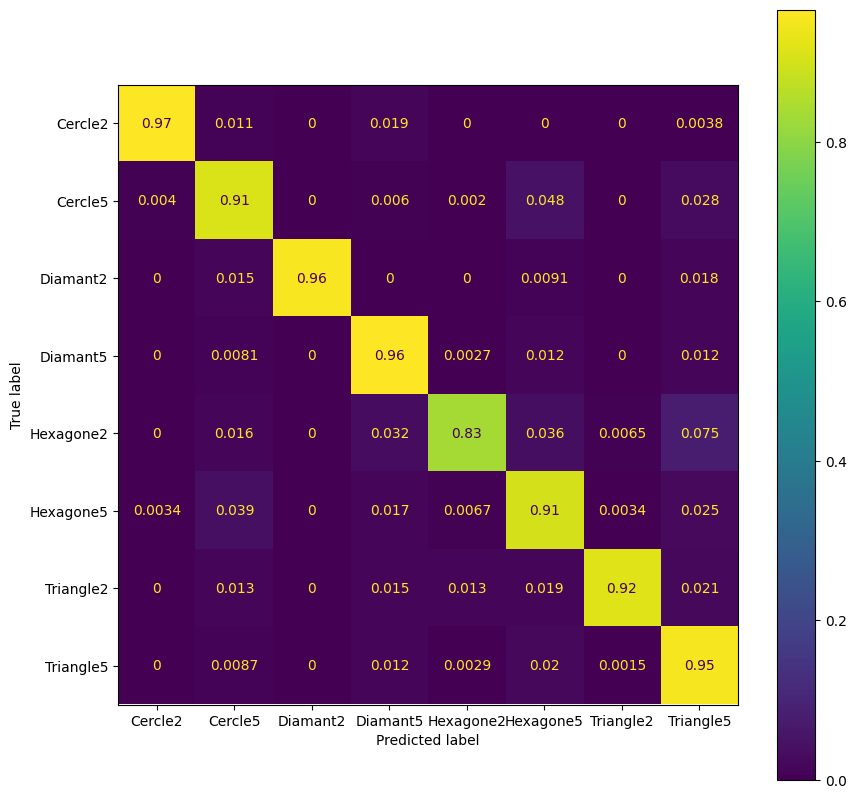

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

# on récupère le nom des classes
class_names = my_dataset.target_names.tolist()

# on crée la matrice de confusion
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_knn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10)) # on agrandit la matrice pour mieux l'observer
cf_disp.plot(ax=ax)

On observe de très bons résultats sur la matrice de confusion. Cela se voit car l'immense majorité des ratios sont sur la diagonale de la matrice.  
Cela signifie que l'immense majorité des éléments prédits sont bien prédits.  
La plus grosse erreur est pour les *Hexagone2* qui sont prédits dans 7,5% des cas en *Triangle5*.

On calcule les accuracy, precision, recall et f1-score :

In [43]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print('Accuracy: %f' % accuracy_knn, '\n')
# precision tp / (tp + fp)
precision_knn = precision_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('Precision: %f' % precision_knn, '\n')
# recall: tp / (tp + fn)
recall_knn = recall_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('Recall: %f' % recall_knn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn = f1_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn, '\n')

Accuracy: 0.931079 

Precision: 0.818684 

Recall: 0.806283 

F1 score: 0.811678 



On observe une très bonne exactitude (accuracy). Ce n'est pas étonnant car la matrice de confusion affiche de très bons résultats et l'accuracy se calcule en multipliant les coefficients diagonaux de la matrice.  

#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

On crée le modèle et on le fit aux données :

In [44]:
from sklearn.svm import SVC

svm_kernel = 'linear' # on met à chaque fois les hyper-paramètres en variables pour pouvoir les afficher

start = time.time()

svm = SVC(kernel = svm_kernel, random_state = 0) # on instancie le modèle

#Entrainer le modèle pour les données

svm.fit(x_train_val, y_train_val.argmax(axis=1)) # on entraine le modèle

end = time.time()

training_time_svm = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm))

temps d'apprentissage : 73.166 secondes


On observe ici un temps d'apprentissage vraiment très long, sans doute dû au grand nombre d'images.

##### B- Phase de prédiction ou de test

On test le modèle sur les données de test :

In [45]:
start = time.time()

y_pred_svm = svm.predict(x_test) # inférence sur les données de test

end = time.time()

testing_time_svm = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm))

temps de test : 12.339 secondes


Le temps de test est également long bien que plus rapide que celui d'apprentissage.  
Ce modèle n'a pas l'air d'être le plus rapide.

##### C- Évaluation

On affiche la matrice de corrélation :

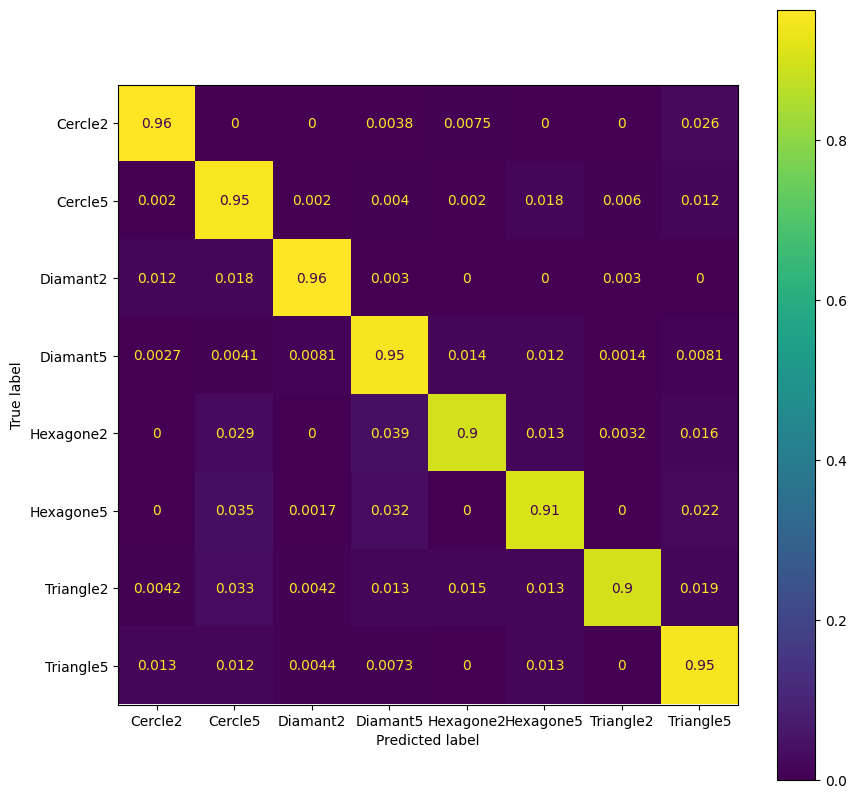

In [46]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_svm,
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

Malgré les temps d'entrainement et de test qui sont longs, le résultat est au rendez-vous avec des résultats encore meilleurs que pour le KNN.
On s'attend donc à une accuracy très élevée.

On calcule les accuracy, precision, recall et f1-score :

In [47]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm = accuracy_score(y_test.argmax(axis=1), y_pred_svm)
print('Accuracy: %f' % accuracy_svm, '\n')
# precision tp / (tp + fp)
precision_svm = precision_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('Precision: %f' % precision_svm, '\n')
# recall: tp / (tp + fn)
recall_svm = recall_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('Recall: %f' % recall_svm, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm = f1_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm, '\n')

Accuracy: 0.936203 

Precision: 0.938253 

Recall: 0.936097 

F1 score: 0.936656 



On retrouve ici une accuracy légèrement supérieure au KNN et surtout une précision, un rappel et un score F1 plus haut de plus de 10%.  
On a ainsi près de 99% de chance, pour une image avec une classe prédite, que l'image soit réellement de cette classe (précision).  

#### 3- Réseau de neurone (NN) model

On réalise les imports nécessaires :

In [48]:
%pip install tensorflow
%pip install keras

import keras
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from keras.layers import BatchNormalization 
from keras.utils import np_utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


##### A-  Créer le modèle du réseau de neurone

On instancie le réseau de neurones en lui ajoutant plusieurs couches :

In [142]:
nn_learning_rate = 0.000001

NN=Sequential()
NN.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu')) # couche d'entrée
NN.add(Dense(500,activation='relu')) #
NN.add(Dense(300,activation='relu')) # couches cachées
NN.add(Dropout(0.2))                 #
NN.add(Dense(len(my_dataset.target_names),activation='softmax')) # couche de sortie
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate) # on utilise une descente du gradient avec moment
NN.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy']) # on compile le modèle

On remarque dans la cellule ci-dessus de nombreux paramètres, on peut choisir le nombre de couches cachées, le type de ces couches, le nombre de noeuds par couche ou encore l'optimisation de descente du gradient  
  
Les choix des couches sont basées sur un exemple existant avec quelques modifications pour optimiser le fonctionnement.  
Le *learning rate* a, cependant, été l'objet de nombreux de tests où le but était de maximiser l'*accuracy* en minimisant le *loss*

On affiche le sommaire du réseau de neurones créé :

In [143]:
NN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 1000)              1622000   
                                                                 
 dense_35 (Dense)            (None, 500)               500500    
                                                                 
 dense_36 (Dense)            (None, 300)               150300    
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_37 (Dense)            (None, 8)                 2408      
                                                                 
Total params: 2,275,208
Trainable params: 2,275,208
Non-trainable params: 0
_________________________________________________________________


##### B- Phase d'apprentissage

On entraine le réseau sur les données de test en utilisant les données de validation pour la propagation en arrière (*backward propagation*) :

In [145]:
nn_nb_epochs = 30 # on a choisi ce nombre d'epoches après avoir entrainé le modèle sur 100 epochs et avoir observé le graphique d'évolution de loss
nn_batch_size = 20 # on utilise un batch size classique

start = time.time()

history= NN.fit(x_train,y_train,validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn))

Epoch 1/30
586/586 [==============================] - 8s 14ms/step - loss: 1.8240 - accuracy: 0.2256 - val_loss: 1.7656 - val_accuracy: 0.2967
Epoch 2/30
586/586 [==============================] - 7s 12ms/step - loss: 1.7587 - accuracy: 0.2695 - val_loss: 1.7138 - val_accuracy: 0.3382
Epoch 3/30
586/586 [==============================] - 7s 12ms/step - loss: 1.7113 - accuracy: 0.3046 - val_loss: 1.6715 - val_accuracy: 0.3738
Epoch 4/30
586/586 [==============================] - 7s 12ms/step - loss: 1.6779 - accuracy: 0.3239 - val_loss: 1.6314 - val_accuracy: 0.3828
Epoch 5/30
586/586 [==============================] - 7s 12ms/step - loss: 1.6418 - accuracy: 0.3508 - val_loss: 1.5957 - val_accuracy: 0.4035
Epoch 6/30
586/586 [==============================] - 7s 12ms/step - loss: 1.6048 - accuracy: 0.3739 - val_loss: 1.5607 - val_accuracy: 0.4343
Epoch 7/30
586/586 [==============================] - 7s 11ms/step - loss: 1.5816 - accuracy: 0.3859 - val_loss: 1.5258 - val_accuracy: 0.4568

On retrouve un temps d'apprentissage très long, typique des réseaux de neurones. Ce temps aurait par ailleurs pu être plus long si on avait entrainé le modèle sur plus d'epochs.

On affiche l'évolution de la perte d'entrainement et de validation :

--------------------------------------------------------------------
Evaluate the trained CNN ...


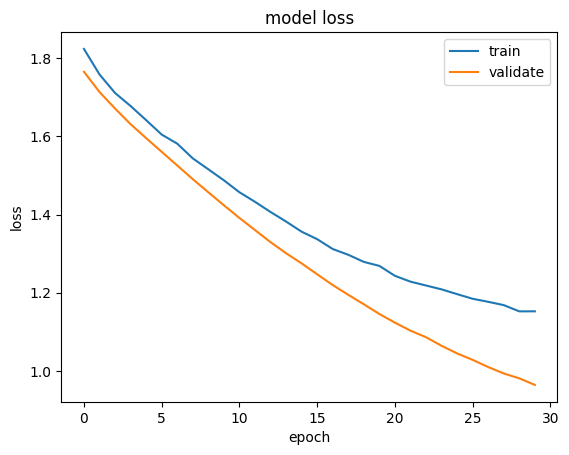

In [146]:
print('--------------------------------------------------------------------\n'
      'Evaluate the trained CNN ...')

# plotting the metrics

fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

On observe que la perte diminue continuellement, ce qui est bon signe et indique qu'on n'a pas un learning rate trop haut.  
La *loss* d'entrainement est légèrement plus forte que celle de validation, signe d'un léger overfitting. Cet ecart reste cependant acceptable.

On regarde maintenant la même chose mais pour l'*accuracy* :

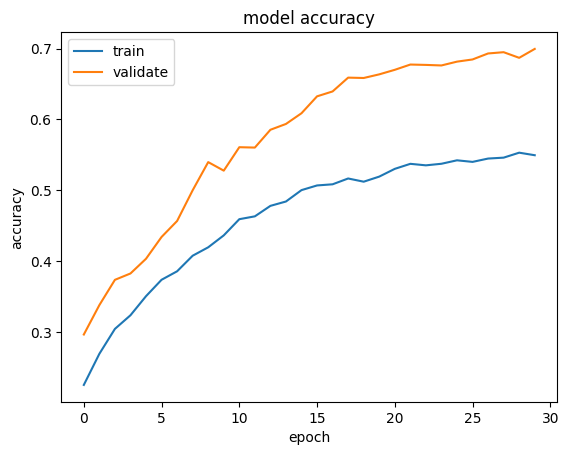

In [147]:
fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

Encore une fois, l'accuracy d'entrainement est légèrement plus faible, signe d'un overfitting. L'ecart est cependant peu élevé et l'overfitting est sans doute dû à notre augmentation des données qui fait qu'on obtient un dataset composé de photos extrêmement similaires.

##### C- Phase de prédiction

On teste maintenant les données de test sur le modèle entrainé :

In [148]:
start = time.time()

y_pred_nn=NN.predict(x_test)

end = time.time()

testing_time_nn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.770 secondes


Ici le temps de test est très court, ce qui est souvent le cas des réseaux de neurones car la compléxité reside dans l'entrainement.

##### D- Évaluation

On observe les *loss* et *accuracy* de test et d'entrainement :

In [149]:
acc_train = NN.evaluate(x_train, y_train)
print("Loss_train:", acc_train[0], " Accuracy_train:", acc_train[1])


acc_test = NN.evaluate(x_test, y_test)
print("Loss_test:", acc_test[0], " Accuracy_test:", acc_test[1])

366/366 [==============================] - 2s 5ms/step - loss: 0.9617 - accuracy: 0.7017
Loss_train: 0.961728036403656  Accuracy_train: 0.7016914486885071
122/122 [==============================] - 1s 5ms/step - loss: 0.9659 - accuracy: 0.6856
Loss_test: 0.9658916592597961  Accuracy_test: 0.6856264472007751


On retrouve ici les différences entre accuracy et loss de test et d'entrainement qu'on a pu visualiser sur les précédents graphiques.

On trace la matrice de confusion associée aux prédictions :

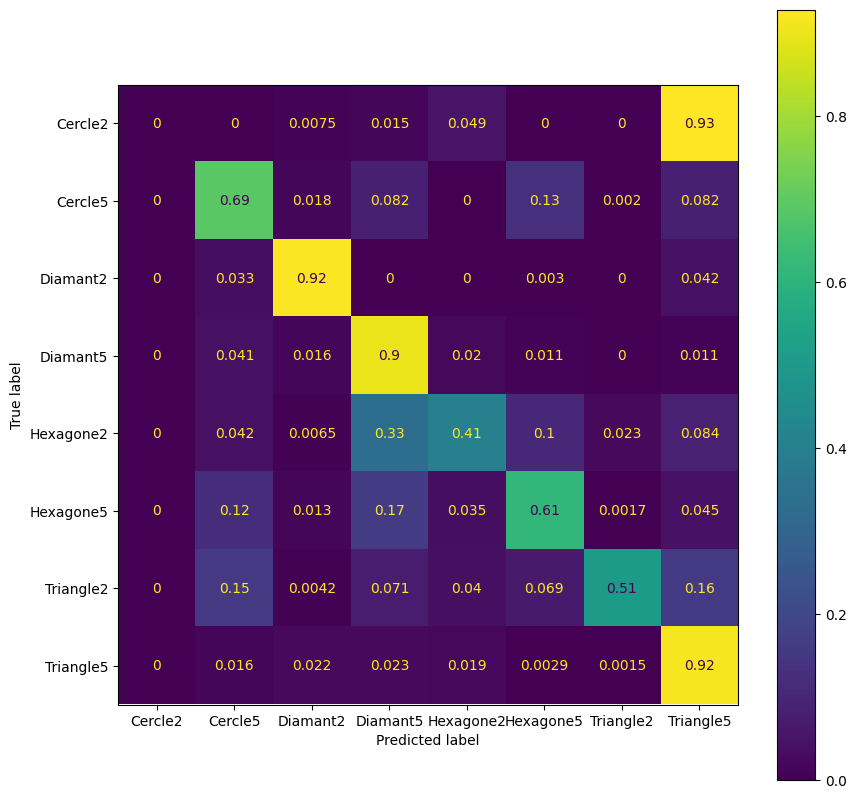

In [150]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_nn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

On observe ici une matrice de confusion avec plus de disparités. Certains éléments sont très bien prédits alors que le modèle a beaucoup plus de difficultés sur d'autres éléments tels que le *Cercle2* qui est presque toujours prédit en *Triangle5*.  
  
Cette erreur très marquée s'explique par le principe de fonctionnement des réseaux de neurones, où certains neurones peuvent faire beaucoup pencher une décision vers une prédiction.

In [151]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn = accuracy_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn, '\n')
# precision tp / (tp + fp)
precision_nn = precision_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn, '\n')
# recall: tp / (tp + fn)
recall_nn = recall_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn = f1_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn, '\n')

Accuracy: 0.685626 

Precision: 0.631437 

Recall: 0.619268 

F1 score: 0.606931 



Sans surprise, on retrouve des évaluations moins bonnes avec une accuracy sous la barre des 70%, ces résultats ne sont cependants pas mauvais mais ce modèle n'est pas le plus adapté à nos données et notre utilisation.

#### 4- Réseau de neurone à convolution (CNN) model



On réalise les imports nécessaires au CNN :

In [58]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

On modifie les dimensions des données car le CNN demande 4 dimensions :

In [59]:
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val_cnn = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print(x_train_cnn.shape, x_val_cnn.shape, x_test_cnn.shape)

(11706, 1621, 1) (3903, 1621, 1) (3903, 1621, 1)


##### A-  Créer le modèle du CNN

A l'instar du NN, on instancie et on paramètre le CNN :

In [60]:
cnn_learning_rate = 0.00000000001 # après de nombreux tests, on choisi un learning rate vraiment petit car c'est la valeur qui fonctionne le mieux

cnn = Sequential()
cnn.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn.add(Dense(16, activation="relu"))
cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1620, 64)          192       
                                                                 
 dense_4 (Dense)             (None, 1620, 16)          1040      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 810, 16)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12960)             0         
                                                                 
 dense_5 (Dense)             (None, 8)                 103688    
                                                                 
Total params: 104,920
Trainable params: 104,920
Non-trainable params: 0
________________________________________________

##### B- Phase d'apprentissage

On entraine maintenant notre modèle sur les données de test :

In [61]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn.fit(x_train_cnn, y_train.argmax(axis=1),validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn))

Epoch 1/20
732/732 [==============================] - 11s 15ms/step - loss: 1.8155 - accuracy: 0.3239 - val_loss: 1.5064 - val_accuracy: 0.4768
Epoch 2/20
732/732 [==============================] - 10s 14ms/step - loss: 1.1832 - accuracy: 0.6278 - val_loss: 1.3345 - val_accuracy: 0.5780
Epoch 3/20
732/732 [==============================] - 10s 14ms/step - loss: 0.8865 - accuracy: 0.7382 - val_loss: 0.8740 - val_accuracy: 0.6918
Epoch 4/20
732/732 [==============================] - 10s 14ms/step - loss: 0.7520 - accuracy: 0.7784 - val_loss: 0.7281 - val_accuracy: 0.8066
Epoch 5/20
732/732 [==============================] - 10s 14ms/step - loss: 0.6624 - accuracy: 0.8095 - val_loss: 0.6024 - val_accuracy: 0.8478
Epoch 6/20
732/732 [==============================] - 10s 14ms/step - loss: 0.5981 - accuracy: 0.8273 - val_loss: 0.7644 - val_accuracy: 0.7853
Epoch 7/20
732/732 [==============================] - 10s 14ms/step - loss: 0.5524 - accuracy: 0.8385 - val_loss: 0.5449 - val_accuracy:

A l'instar du modèle précédent, ce réseau de neurones possède un long temps d'apprentissage.

On affiche les *loss* et *accuracy* du modèle en fonction des epochs :

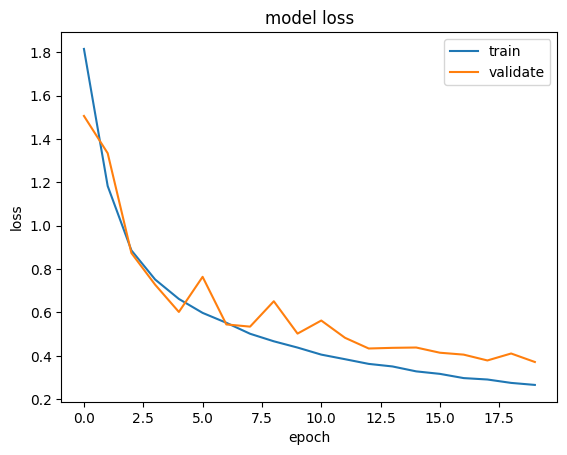

In [62]:
fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()


On remarque deux belles courbes qui descendent au début beaucoup puis de moins en moins jusqu'à stagner vers une valeur de loss assez faible.  
Les deux courbes sont proches, ce qui indique que l'overfitting est limité.  
Par ailleurs, le learning rate semble adéquat vu l'allure des courbes avec une forte descente et pas de remontée.

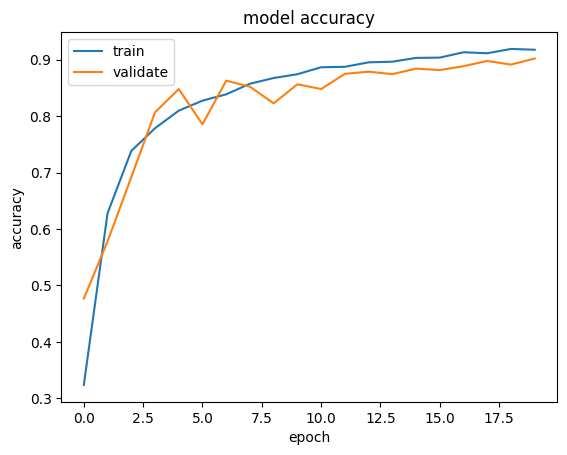

In [63]:
fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

A l'image du graphique précédent, ce graphique montre deux belles courbes qui témoignent du fait qu'il n'y a quasiment pas d'overfitting ni de divergence de la loss.  
La valeur d'accuracy atteinte est par ailleurs très satisfaisante.

##### C- Phase de prédiction

On réalise l'inférence des exemples de test sur le modèle :

In [64]:
start = time.time()

y_pred_cnn = cnn.predict(x_test_cnn)

end = time.time()

testing_time_cnn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn))

122/122 [==============================] - 1s 10ms/step
temps de test : 1.447 secondes


Encore une fois, grâce au principe de fonctionnement des réseaux de neurones : le test est très rapide par rapport à l'entrainement.

##### D- Évaluation

On calcule les *loss* et *accuracy* :

In [65]:
acc_train = cnn.evaluate(x_train_cnn, y_train.argmax(axis=1))
print("Loss_train:", acc_train[0], " Accuracy_train:", acc_train[1])


acc_test = cnn.evaluate(x_test_cnn, y_test.argmax(axis=1))
print("Loss_test:", acc_test[0], " Accuracy_test:", acc_test[1])

366/366 [==============================] - 4s 11ms/step - loss: 0.2124 - accuracy: 0.9382
Loss_train: 0.2123938798904419  Accuracy_train: 0.9382367730140686
122/122 [==============================] - 1s 10ms/step - loss: 0.3582 - accuracy: 0.8950
Loss_test: 0.3581758439540863  Accuracy_test: 0.8949525952339172


Ces valeurs vérifient ce qu'on a vu sur les précédents graphiques, avec des valeurs similaires entre test et entrainement et une accuracy très bonne.

On affiche maintenant la matrice de confusion :

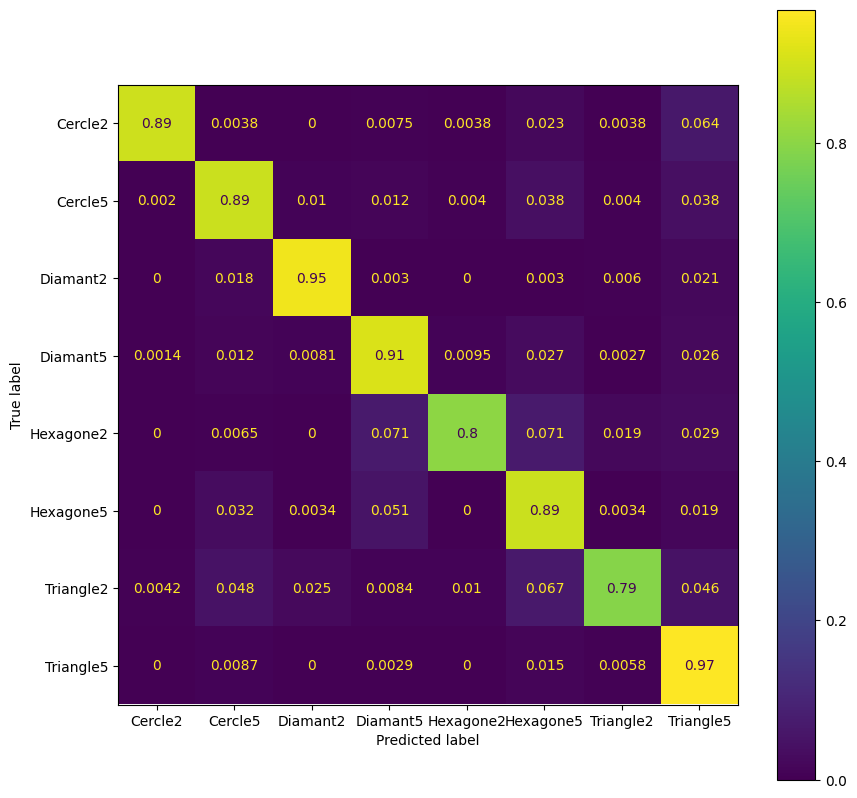

In [66]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_cnn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

Les bons résultats vus précédemment expliquent cette matrice de confusion qui montre un modèle très performant, aucune étiquette n'est mal prédite et la pire est le *Triangle2* qui n'a "que" 79% d'être correctement prédit. Il est sinon la plupart du temps prédit en *Hexagone5*.

Enfin, on calcule l'accuracy, la précision, le recall et le f1_score :

In [67]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn = accuracy_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn, '\n')
# precision tp / (tp + fp)
precision_cnn = precision_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn, '\n')
# recall: tp / (tp + fn)
recall_cnn = recall_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn = f1_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn, '\n')

Accuracy: 0.894953 

Precision: 0.909796 

Recall: 0.887780 

F1 score: 0.896340 



On retrouve des bonnes valeurs d'évaluation, avec presque 90% d'accuracy.  
Ce modèle n'est pas le meilleur dans notre cas mais il est déjà bien plus performant que le réseau de neurones classique implémenté précédemment.

***

Pour les tests de scalabilté qui vont suivre, les résultats ne sont pas commentés car ils sont directement commentés dans la section *Synthèse des résultats* à la fin du notebook.

### Avec 60% des données

On réalise les mêmes opérations que la section précédente mais avec 60% des données d'entrainement.
  
On calcule le nombre d'images à conserver dans l'ensemble d'entrainement :

In [68]:
nb_train_images_60 = int(x_train.shape[0]*0.6)

nb_train_images_60

7023

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [69]:
import time

knn_n_neighbors = 1

start = time.time()

knn_60 = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn_60.fit(x_train_val[:nb_train_images_60,:],y_train_val[:nb_train_images_60,:]) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn_60 = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn_60))

temps d'apprentissage : 0.016 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [70]:
start = time.time()

y_pred_knn_60 = knn_60.predict(x_test)

end = time.time()

testing_time_knn_60 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn_60))
print(y_pred.shape, y_test.shape)

temps de test : 1.354 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

In [71]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn_60 = accuracy_score(y_test, y_pred_knn_60)
print('Accuracy: %f' % accuracy_knn_60, '\n')
# precision tp / (tp + fp)
precision_knn_60 = precision_score(y_test, y_pred_knn_60, average='macro', zero_division=0)
print('Precision: %f' % precision_knn_60, '\n')
# recall: tp / (tp + fn)
recall_knn_60 = recall_score(y_test, y_pred_knn_60, average='macro', zero_division=0)
print('Recall: %f' % recall_knn_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn_60 = f1_score(y_test, y_pred_knn_60, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn_60, '\n')

Accuracy: 0.894440 

Precision: 0.792794 

Recall: 0.770635 

F1 score: 0.779747 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

In [72]:
from sklearn.svm import SVC

svm_kernel = 'linear'

start = time.time()

svm_60 = SVC(kernel = svm_kernel, random_state = 0)

#Entrainer le modèle pour les données

svm_60.fit(x_train_val[:nb_train_images_60,:], y_train_val[:nb_train_images_60,:].argmax(axis=1))

end = time.time()

training_time_svm_60 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm_60))

temps d'apprentissage : 19.691 secondes


##### B- Phase de prédiction ou de test

In [73]:
start = time.time()

y_pred_svm_60 = svm_60.predict(x_test)

end = time.time()

testing_time_svm_60 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm_60))

temps de test : 6.721 secondes


##### C- Évaluation

In [74]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm_60 = accuracy_score(y_test.argmax(axis=1), y_pred_svm_60)
print('Accuracy: %f' % accuracy_svm_60, '\n')
# precision tp / (tp + fp)
precision_svm_60 = precision_score(y_test.argmax(axis=1), y_pred_svm_60, average='macro', zero_division=0)
print('Precision: %f' % precision_svm_60, '\n')
# recall: tp / (tp + fn)
recall_svm_60 = recall_score(y_test.argmax(axis=1), y_pred_svm_60, average='macro', zero_division=0)
print('Recall: %f' % recall_svm_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_60 = f1_score(y_test.argmax(axis=1), y_pred_svm_60, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm_60, '\n')

Accuracy: 0.910325 

Precision: 0.909895 

Recall: 0.907591 

F1 score: 0.907732 



#### 3- Réseau de neurone (NN) model

##### A-  Créer le modèle du réseau de neurone

In [75]:
nn_learning_rate = 0.000001

NN_60=Sequential()
NN_60.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu'))
NN_60.add(Dense(500,activation='relu'))
NN_60.add(Dense(300,activation='relu'))
NN_60.add(Dropout(0.2))
NN_60.add(Dense(len(my_dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate)
NN_60.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

##### B- Phase d'apprentissage

In [76]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN_60.fit(x_train[:nb_train_images_60,:],y_train[:nb_train_images_60,:],validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn_60 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn_60))

Epoch 1/20
352/352 [==============================] - 5s 13ms/step - loss: 1.9818 - accuracy: 0.1421 - val_loss: 1.8692 - val_accuracy: 0.2247
Epoch 2/20
352/352 [==============================] - 4s 12ms/step - loss: 1.8374 - accuracy: 0.2237 - val_loss: 1.8015 - val_accuracy: 0.2683
Epoch 3/20
352/352 [==============================] - 4s 12ms/step - loss: 1.7850 - accuracy: 0.2529 - val_loss: 1.7591 - val_accuracy: 0.3028
Epoch 4/20
352/352 [==============================] - 4s 12ms/step - loss: 1.7537 - accuracy: 0.2713 - val_loss: 1.7281 - val_accuracy: 0.3244
Epoch 5/20
352/352 [==============================] - 4s 12ms/step - loss: 1.7244 - accuracy: 0.2923 - val_loss: 1.6990 - val_accuracy: 0.3438
Epoch 6/20
352/352 [==============================] - 5s 13ms/step - loss: 1.6969 - accuracy: 0.3091 - val_loss: 1.6741 - val_accuracy: 0.3446
Epoch 7/20
352/352 [==============================] - 4s 13ms/step - loss: 1.6765 - accuracy: 0.3155 - val_loss: 1.6499 - val_accuracy: 0.3543

##### C- Phase de prédiction

In [77]:
start = time.time()

y_pred_nn_60=NN_60.predict(x_test)

end = time.time()

testing_time_nn_60 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn_60))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.765 secondes


##### D- Évaluation

In [78]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn_60 = accuracy_score(y_test.argmax(axis=1), y_pred_nn_60.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn_60, '\n')
# precision tp / (tp + fp)
precision_nn_60 = precision_score(y_test.argmax(axis=1), y_pred_nn_60.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn_60, '\n')
# recall: tp / (tp + fn)
recall_nn_60 = recall_score(y_test.argmax(axis=1), y_pred_nn_60.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn_60 = f1_score(y_test.argmax(axis=1), y_pred_nn_60.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn_60, '\n')

Accuracy: 0.521138 

Precision: 0.516135 

Recall: 0.432891 

F1 score: 0.427584 



#### 4- Réseau de neurone à convolution (CNN) model



##### A-  Créer le modèle du CNN

In [79]:
cnn_learning_rate = 0.00000000001

cnn_60 = Sequential()
cnn_60.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn_60.add(Dense(16, activation="relu"))
cnn_60.add(MaxPooling1D())
cnn_60.add(Flatten())
cnn_60.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn_60.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])

##### B- Phase d'apprentissage

In [80]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn_60.fit(x_train_cnn[:nb_train_images_60,:], y_train[:nb_train_images_60,:].argmax(axis=1),
                    validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn_60 = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn_60))

Epoch 1/20
439/439 [==============================] - 7s 16ms/step - loss: 1.9248 - accuracy: 0.2730 - val_loss: 1.7599 - val_accuracy: 0.3810
Epoch 2/20
439/439 [==============================] - 7s 16ms/step - loss: 1.4697 - accuracy: 0.5068 - val_loss: 1.2222 - val_accuracy: 0.5585
Epoch 3/20
439/439 [==============================] - 7s 17ms/step - loss: 1.1318 - accuracy: 0.6500 - val_loss: 0.9355 - val_accuracy: 0.7351
Epoch 4/20
439/439 [==============================] - 7s 17ms/step - loss: 0.9295 - accuracy: 0.7192 - val_loss: 0.7618 - val_accuracy: 0.7881
Epoch 5/20
439/439 [==============================] - 7s 16ms/step - loss: 0.8193 - accuracy: 0.7531 - val_loss: 0.7724 - val_accuracy: 0.7804
Epoch 6/20
439/439 [==============================] - 7s 15ms/step - loss: 0.7220 - accuracy: 0.7831 - val_loss: 0.7466 - val_accuracy: 0.7909
Epoch 7/20
439/439 [==============================] - 7s 15ms/step - loss: 0.6749 - accuracy: 0.8039 - val_loss: 0.6452 - val_accuracy: 0.8178

##### C- Phase de prédiction

In [81]:
start = time.time()

y_pred_cnn_60 = cnn_60.predict(x_test_cnn)

end = time.time()

testing_time_cnn_60 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn_60))

122/122 [==============================] - 1s 10ms/step
temps de test : 1.367 secondes


##### D- Évaluation

In [82]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn_60 = accuracy_score(y_test.argmax(axis=1), y_pred_cnn_60.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn_60, '\n')
# precision tp / (tp + fp)
precision_cnn_60 = precision_score(y_test.argmax(axis=1), y_pred_cnn_60.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn_60, '\n')
# recall: tp / (tp + fn)
recall_cnn_60 = recall_score(y_test.argmax(axis=1), y_pred_cnn_60.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn_60 = f1_score(y_test.argmax(axis=1), y_pred_cnn_60.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn_60, '\n')

Accuracy: 0.875993 

Precision: 0.883119 

Recall: 0.877707 

F1 score: 0.878849 



### Avec 80% des données

On réalise les mêmes opérations que la section précédente mais avec 80% des données d'entrainement.
  
On calcule le nombre d'images à conserver dans l'ensemble d'entrainement :

In [83]:
nb_train_images_80 = int(x_train.shape[0]*0.8)

nb_train_images_80

9364

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [84]:
import time

knn_n_neighbors = 1

start = time.time()

knn_80 = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn_80.fit(x_train_val[:nb_train_images_80,:],y_train_val[:nb_train_images_80,:]) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn_80 = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn_80))

temps d'apprentissage : 0.031 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [85]:
start = time.time()

y_pred_knn_80 = knn_80.predict(x_test)

end = time.time()

testing_time_knn_80 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn_80))
print(y_pred.shape, y_test.shape)

temps de test : 1.504 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

In [86]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn_80 = accuracy_score(y_test, y_pred_knn_80)
print('Accuracy: %f' % accuracy_knn_80, '\n')
# precision tp / (tp + fp)
precision_knn_80 = precision_score(y_test, y_pred_knn_80, average='macro', zero_division=0)
print('Precision: %f' % precision_knn_80, '\n')
# recall: tp / (tp + fn)
recall_knn_80 = recall_score(y_test, y_pred_knn_80, average='macro', zero_division=0)
print('Recall: %f' % recall_knn_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn_80 = f1_score(y_test, y_pred_knn_80, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn_80, '\n')

Accuracy: 0.909557 

Precision: 0.802976 

Recall: 0.785194 

F1 score: 0.792575 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

In [87]:
from sklearn.svm import SVC

svm_kernel = 'linear'

start = time.time()

svm_80 = SVC(kernel = svm_kernel, random_state = 0)

#Entrainer le modèle pour les données

svm_80.fit(x_train_val[:nb_train_images_80,:], y_train_val[:nb_train_images_80,:].argmax(axis=1))

end = time.time()

training_time_svm_80 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm_80))

temps d'apprentissage : 29.098 secondes


##### B- Phase de prédiction ou de test

In [88]:
start = time.time()

y_pred_svm_80 = svm_80.predict(x_test)

end = time.time()

testing_time_svm_80 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm_80))

temps de test : 8.378 secondes


##### C- Évaluation

In [89]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm_80 = accuracy_score(y_test.argmax(axis=1), y_pred_svm_80)
print('Accuracy: %f' % accuracy_svm_80, '\n')
# precision tp / (tp + fp)
precision_svm_80 = precision_score(y_test.argmax(axis=1), y_pred_svm_80, average='macro', zero_division=0)
print('Precision: %f' % precision_svm_80, '\n')
# recall: tp / (tp + fn)
recall_svm_80 = recall_score(y_test.argmax(axis=1), y_pred_svm_80, average='macro', zero_division=0)
print('Recall: %f' % recall_svm_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_80 = f1_score(y_test.argmax(axis=1), y_pred_svm_80, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm_80, '\n')

Accuracy: 0.924673 

Precision: 0.924549 

Recall: 0.924706 

F1 score: 0.924206 



#### 3- Réseau de neurone (NN) model

##### A-  Créer le modèle du réseau de neurone

In [90]:
nn_learning_rate = 0.000001

NN_80=Sequential()
NN_80.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu'))
NN_80.add(Dense(500,activation='relu'))
NN_80.add(Dense(300,activation='relu'))
NN_80.add(Dropout(0.2))
NN_80.add(Dense(len(my_dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate)
NN_80.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

##### B- Phase d'apprentissage

In [91]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN_80.fit(x_train[:nb_train_images_80,:],y_train[:nb_train_images_80,:],validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn_80 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn_80))

Epoch 1/20
469/469 [==============================] - 6s 12ms/step - loss: 1.9141 - accuracy: 0.1815 - val_loss: 1.8257 - val_accuracy: 0.2665
Epoch 2/20
469/469 [==============================] - 5s 12ms/step - loss: 1.8045 - accuracy: 0.2478 - val_loss: 1.7676 - val_accuracy: 0.3082
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 1.7561 - accuracy: 0.2831 - val_loss: 1.7237 - val_accuracy: 0.3210
Epoch 4/20
469/469 [==============================] - 5s 12ms/step - loss: 1.7164 - accuracy: 0.3071 - val_loss: 1.6884 - val_accuracy: 0.3369
Epoch 5/20
469/469 [==============================] - 6s 12ms/step - loss: 1.6936 - accuracy: 0.3225 - val_loss: 1.6579 - val_accuracy: 0.3372
Epoch 6/20
469/469 [==============================] - 6s 12ms/step - loss: 1.6616 - accuracy: 0.3450 - val_loss: 1.6286 - val_accuracy: 0.3866
Epoch 7/20
469/469 [==============================] - 6s 12ms/step - loss: 1.6297 - accuracy: 0.3631 - val_loss: 1.5993 - val_accuracy: 0.4071

##### C- Phase de prédiction

In [92]:
start = time.time()

y_pred_nn_80=NN_80.predict(x_test)

end = time.time()

testing_time_nn_80 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn_80))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.779 secondes


##### D- Évaluation

In [93]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn_80 = accuracy_score(y_test.argmax(axis=1), y_pred_nn_80.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn_80, '\n')
# precision tp / (tp + fp)
precision_nn_80 = precision_score(y_test.argmax(axis=1), y_pred_nn_80.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn_80, '\n')
# recall: tp / (tp + fn)
recall_nn_80 = recall_score(y_test.argmax(axis=1), y_pred_nn_80.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn_80 = f1_score(y_test.argmax(axis=1), y_pred_nn_80.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn_80, '\n')

Accuracy: 0.607738 

Precision: 0.601620 

Recall: 0.523323 

F1 score: 0.522154 



#### 4- Réseau de neurone à convolution (CNN) model


##### A-  Créer le modèle du CNN

In [94]:
cnn_learning_rate = 0.00000000001

cnn_80 = Sequential()
cnn_80.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn_80.add(Dense(16, activation="relu"))
cnn_80.add(MaxPooling1D())
cnn_80.add(Flatten())
cnn_80.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn_80.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])

##### B- Phase d'apprentissage

In [95]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn_80.fit(x_train_cnn[:nb_train_images_80,:], y_train[:nb_train_images_80,:].argmax(axis=1),
                    validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn_80 = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn_80))

Epoch 1/20
586/586 [==============================] - 10s 16ms/step - loss: 1.8873 - accuracy: 0.3016 - val_loss: 1.7520 - val_accuracy: 0.3543
Epoch 2/20
586/586 [==============================] - 9s 16ms/step - loss: 1.3304 - accuracy: 0.5690 - val_loss: 1.1672 - val_accuracy: 0.6200
Epoch 3/20
586/586 [==============================] - 9s 16ms/step - loss: 1.0164 - accuracy: 0.6884 - val_loss: 0.9387 - val_accuracy: 0.7148
Epoch 4/20
586/586 [==============================] - 9s 16ms/step - loss: 0.8432 - accuracy: 0.7479 - val_loss: 0.8203 - val_accuracy: 0.7420
Epoch 5/20
586/586 [==============================] - 9s 16ms/step - loss: 0.7467 - accuracy: 0.7804 - val_loss: 1.4736 - val_accuracy: 0.5901
Epoch 6/20
586/586 [==============================] - 9s 16ms/step - loss: 0.6895 - accuracy: 0.7978 - val_loss: 0.8644 - val_accuracy: 0.7405
Epoch 7/20
586/586 [==============================] - 9s 16ms/step - loss: 0.6308 - accuracy: 0.8118 - val_loss: 0.6286 - val_accuracy: 0.810

##### C- Phase de prédiction

In [96]:
start = time.time()

y_pred_cnn_80 = cnn_80.predict(x_test_cnn)

end = time.time()

testing_time_cnn_80 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn_80))

122/122 [==============================] - 1s 11ms/step
temps de test : 1.555 secondes


##### D- Évaluation

In [97]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn_80 = accuracy_score(y_test.argmax(axis=1), y_pred_cnn_80.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn_80, '\n')
# precision tp / (tp + fp)
precision_cnn_80 = precision_score(y_test.argmax(axis=1), y_pred_cnn_80.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn_80, '\n')
# recall: tp / (tp + fn)
recall_cnn_80 = recall_score(y_test.argmax(axis=1), y_pred_cnn_80.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn_80 = f1_score(y_test.argmax(axis=1), y_pred_cnn_80.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn_80, '\n')

Accuracy: 0.861132 

Precision: 0.888712 

Recall: 0.852517 

F1 score: 0.861722 



### Avec 40% des données

On réalise les mêmes opérations que la section précédente mais avec 40% des données d'entrainement.
  
On calcule le nombre d'images à conserver dans l'ensemble d'entrainement :

In [98]:
nb_train_images_40 = int(x_train.shape[0]*0.4)

nb_train_images_40

4682

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [99]:
import time

knn_n_neighbors = 1

start = time.time()

knn_40 = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn_40.fit(x_train_val[:nb_train_images_40,:],y_train_val[:nb_train_images_40,:]) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn_40 = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn_40))

temps d'apprentissage : 0.008 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [100]:
start = time.time()

y_pred_knn_40 = knn_40.predict(x_test)

end = time.time()

testing_time_knn_40 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn_40))
print(y_pred.shape, y_test.shape)

temps de test : 1.171 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

In [101]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn_40 = accuracy_score(y_test, y_pred_knn_40)
print('Accuracy: %f' % accuracy_knn_40, '\n')
# precision tp / (tp + fp)
precision_knn_40 = precision_score(y_test, y_pred_knn_40, average='macro', zero_division=0)
print('Precision: %f' % precision_knn_40, '\n')
# recall: tp / (tp + fn)
recall_knn_40 = recall_score(y_test, y_pred_knn_40, average='macro', zero_division=0)
print('Recall: %f' % recall_knn_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn_40 = f1_score(y_test, y_pred_knn_40, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn_40, '\n')

Accuracy: 0.868563 

Precision: 0.771099 

Recall: 0.743928 

F1 score: 0.754474 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

In [102]:
from sklearn.svm import SVC

svm_kernel = 'linear'

start = time.time()

svm_40 = SVC(kernel = svm_kernel, random_state = 0)

#Entrainer le modèle pour les données

svm_40.fit(x_train_val[:nb_train_images_40,:], y_train_val[:nb_train_images_40,:].argmax(axis=1))

end = time.time()

training_time_svm_40 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm_40))

temps d'apprentissage : 9.697 secondes


##### B- Phase de prédiction ou de test

In [103]:
start = time.time()

y_pred_svm_40 = svm_40.predict(x_test)

end = time.time()

testing_time_svm_40 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm_40))

temps de test : 6.832 secondes


##### C- Évaluation

In [104]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm_40 = accuracy_score(y_test.argmax(axis=1), y_pred_svm_40)
print('Accuracy: %f' % accuracy_svm_40, '\n')
# precision tp / (tp + fp)
precision_svm_40 = precision_score(y_test.argmax(axis=1), y_pred_svm_40, average='macro', zero_division=0)
print('Precision: %f' % precision_svm_40, '\n')
# recall: tp / (tp + fn)
recall_svm_40 = recall_score(y_test.argmax(axis=1), y_pred_svm_40, average='macro', zero_division=0)
print('Recall: %f' % recall_svm_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_40 = f1_score(y_test.argmax(axis=1), y_pred_svm_40, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm_40, '\n')

Accuracy: 0.903920 

Precision: 0.906053 

Recall: 0.901400 

F1 score: 0.902654 



#### 3- Réseau de neurone (NN) model

##### A-  Créer le modèle du réseau de neurone

In [105]:
nn_learning_rate = 0.000001

NN_40=Sequential()
NN_40.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu'))
NN_40.add(Dense(500,activation='relu'))
NN_40.add(Dense(300,activation='relu'))
NN_40.add(Dropout(0.2))
NN_40.add(Dense(len(my_dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate)
NN_40.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

##### B- Phase d'apprentissage

In [106]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN_40.fit(x_train[:nb_train_images_40,:],y_train[:nb_train_images_40,:],validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn_40 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn_40))

Epoch 1/20
235/235 [==============================] - 4s 14ms/step - loss: 1.8884 - accuracy: 0.1632 - val_loss: 1.8347 - val_accuracy: 0.1847
Epoch 2/20
235/235 [==============================] - 3s 13ms/step - loss: 1.8240 - accuracy: 0.1747 - val_loss: 1.8006 - val_accuracy: 0.1970
Epoch 3/20
235/235 [==============================] - 3s 14ms/step - loss: 1.7901 - accuracy: 0.1897 - val_loss: 1.7769 - val_accuracy: 0.2314
Epoch 4/20
235/235 [==============================] - 3s 14ms/step - loss: 1.7673 - accuracy: 0.2215 - val_loss: 1.7560 - val_accuracy: 0.2621
Epoch 5/20
235/235 [==============================] - 3s 14ms/step - loss: 1.7443 - accuracy: 0.2443 - val_loss: 1.7369 - val_accuracy: 0.2895
Epoch 6/20
235/235 [==============================] - 3s 14ms/step - loss: 1.7394 - accuracy: 0.2390 - val_loss: 1.7205 - val_accuracy: 0.3123
Epoch 7/20
235/235 [==============================] - 3s 14ms/step - loss: 1.7165 - accuracy: 0.2663 - val_loss: 1.7047 - val_accuracy: 0.3277

##### C- Phase de prédiction

In [107]:
start = time.time()

y_pred_nn_40=NN_40.predict(x_test)

end = time.time()

testing_time_nn_40 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn_40))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.716 secondes


##### D- Évaluation

In [108]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn_40 = accuracy_score(y_test.argmax(axis=1), y_pred_nn_40.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn_40, '\n')
# precision tp / (tp + fp)
precision_nn_40 = precision_score(y_test.argmax(axis=1), y_pred_nn_40.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn_40, '\n')
# recall: tp / (tp + fn)
recall_nn_40 = recall_score(y_test.argmax(axis=1), y_pred_nn_40.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn_40 = f1_score(y_test.argmax(axis=1), y_pred_nn_40.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn_40, '\n')

Accuracy: 0.484243 

Precision: 0.512402 

Recall: 0.405442 

F1 score: 0.396568 



#### 4- Réseau de neurone à convolution (CNN) model



##### A-  Créer le modèle du CNN

In [109]:
cnn_learning_rate = 0.00000000001

cnn_40 = Sequential()
cnn_40.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn_40.add(Dense(16, activation="relu"))
cnn_40.add(MaxPooling1D())
cnn_40.add(Flatten())
cnn_40.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn_40.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])

##### B- Phase d'apprentissage

In [110]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn_40.fit(x_train_cnn[:nb_train_images_40,:], y_train[:nb_train_images_40,:].argmax(axis=1),
                    validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn_40 = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn_40))

Epoch 1/20
293/293 [==============================] - 6s 17ms/step - loss: 1.9954 - accuracy: 0.2377 - val_loss: 1.8887 - val_accuracy: 0.3554
Epoch 2/20
293/293 [==============================] - 5s 17ms/step - loss: 1.7144 - accuracy: 0.4003 - val_loss: 1.6906 - val_accuracy: 0.4230
Epoch 3/20
293/293 [==============================] - 5s 17ms/step - loss: 1.3738 - accuracy: 0.5589 - val_loss: 1.7323 - val_accuracy: 0.4381
Epoch 4/20
293/293 [==============================] - 5s 18ms/step - loss: 1.1731 - accuracy: 0.6333 - val_loss: 1.0667 - val_accuracy: 0.7143
Epoch 5/20
293/293 [==============================] - 5s 18ms/step - loss: 1.0189 - accuracy: 0.6871 - val_loss: 1.0517 - val_accuracy: 0.6656
Epoch 6/20
293/293 [==============================] - 5s 16ms/step - loss: 0.9288 - accuracy: 0.7100 - val_loss: 0.7922 - val_accuracy: 0.7756
Epoch 7/20
293/293 [==============================] - 5s 17ms/step - loss: 0.8486 - accuracy: 0.7499 - val_loss: 1.1095 - val_accuracy: 0.6877

##### C- Phase de prédiction

In [111]:
start = time.time()

y_pred_cnn_40 = cnn_40.predict(x_test_cnn)

end = time.time()

testing_time_cnn_40 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn_40))

122/122 [==============================] - 1s 11ms/step
temps de test : 1.452 secondes


##### D- Évaluation

In [112]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn_40 = accuracy_score(y_test.argmax(axis=1), y_pred_cnn_40.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn_40, '\n')
# precision tp / (tp + fp)
precision_cnn_40 = precision_score(y_test.argmax(axis=1), y_pred_cnn_40.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn_40, '\n')
# recall: tp / (tp + fn)
recall_cnn_40 = recall_score(y_test.argmax(axis=1), y_pred_cnn_40.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn_40 = f1_score(y_test.argmax(axis=1), y_pred_cnn_40.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn_40, '\n')

Accuracy: 0.806559 

Precision: 0.846926 

Recall: 0.814901 

F1 score: 0.815353 



### Avec 20% de données

On réalise les mêmes opérations que la section précédente mais avec 20% des données d'entrainement.
  
On calcule le nombre d'images à conserver dans l'ensemble d'entrainement :

In [113]:
nb_train_images_20 = int(x_train.shape[0]*0.2)

nb_train_images_20

2341

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [114]:
import time

knn_n_neighbors = 1

start = time.time()

knn_20 = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn_20.fit(x_train_val[:nb_train_images_20,:],y_train_val[:nb_train_images_20,:]) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn_20 = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn_20))

temps d'apprentissage : 0.008 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [115]:
start = time.time()

y_pred_knn_20 = knn_20.predict(x_test)

end = time.time()

testing_time_knn_20 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn_20))
print(y_pred.shape, y_test.shape)

temps de test : 0.875 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

In [116]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn_20 = accuracy_score(y_test, y_pred_knn_20)
print('Accuracy: %f' % accuracy_knn_20, '\n')
# precision tp / (tp + fp)
precision_knn_20 = precision_score(y_test, y_pred_knn_20, average='macro', zero_division=0)
print('Precision: %f' % precision_knn_20, '\n')
# recall: tp / (tp + fn)
recall_knn_20 = recall_score(y_test, y_pred_knn_20, average='macro', zero_division=0)
print('Recall: %f' % recall_knn_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn_20 = f1_score(y_test, y_pred_knn_20, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn_20, '\n')

Accuracy: 0.803997 

Precision: 0.718592 

Recall: 0.683493 

F1 score: 0.695673 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

In [117]:
from sklearn.svm import SVC

svm_kernel = 'linear'

start = time.time()

svm_20 = SVC(kernel = svm_kernel, random_state = 0)

#Entrainer le modèle pour les données

svm_20.fit(x_train_val[:nb_train_images_20,:], y_train_val[:nb_train_images_20,:].argmax(axis=1))

end = time.time()

training_time_svm_20 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm_20))

temps d'apprentissage : 3.148 secondes


##### B- Phase de prédiction ou de test

In [118]:
start = time.time()

y_pred_svm_20 = svm_20.predict(x_test)

end = time.time()

testing_time_svm_20 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm_20))

temps de test : 3.422 secondes


##### C- Évaluation

In [119]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm_20 = accuracy_score(y_test.argmax(axis=1), y_pred_svm_20)
print('Accuracy: %f' % accuracy_svm_20, '\n')
# precision tp / (tp + fp)
precision_svm_20 = precision_score(y_test.argmax(axis=1), y_pred_svm_20, average='macro', zero_division=0)
print('Precision: %f' % precision_svm_20, '\n')
# recall: tp / (tp + fn)
recall_svm_20 = recall_score(y_test.argmax(axis=1), y_pred_svm_20, average='macro', zero_division=0)
print('Recall: %f' % recall_svm_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_20 = f1_score(y_test.argmax(axis=1), y_pred_svm_20, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm_20, '\n')

Accuracy: 0.872918 

Precision: 0.875499 

Recall: 0.867484 

F1 score: 0.869808 



#### 3- Réseau de neurone (NN) model

##### A-  Créer le modèle du réseau de neurone

In [120]:
nn_learning_rate = 0.000001

NN_20=Sequential()
NN_20.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu'))
NN_20.add(Dense(500,activation='relu'))
NN_20.add(Dense(300,activation='relu'))
NN_20.add(Dropout(0.2))
NN_20.add(Dense(len(my_dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate)
NN_20.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

##### B- Phase d'apprentissage

In [121]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN_20.fit(x_train[:nb_train_images_20,:],y_train[:nb_train_images_20,:],validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn_20 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn_20))

Epoch 1/20
118/118 [==============================] - 2s 17ms/step - loss: 2.0545 - accuracy: 0.0880 - val_loss: 1.9719 - val_accuracy: 0.1097
Epoch 2/20
118/118 [==============================] - 2s 16ms/step - loss: 1.9440 - accuracy: 0.1418 - val_loss: 1.9094 - val_accuracy: 0.2229
Epoch 3/20
118/118 [==============================] - 2s 16ms/step - loss: 1.8987 - accuracy: 0.1811 - val_loss: 1.8721 - val_accuracy: 0.2298
Epoch 4/20
118/118 [==============================] - 2s 15ms/step - loss: 1.8591 - accuracy: 0.2025 - val_loss: 1.8463 - val_accuracy: 0.2396
Epoch 5/20
118/118 [==============================] - 2s 17ms/step - loss: 1.8425 - accuracy: 0.2119 - val_loss: 1.8272 - val_accuracy: 0.2472
Epoch 6/20
118/118 [==============================] - 2s 16ms/step - loss: 1.8193 - accuracy: 0.2234 - val_loss: 1.8114 - val_accuracy: 0.2629
Epoch 7/20
118/118 [==============================] - 2s 15ms/step - loss: 1.8107 - accuracy: 0.2217 - val_loss: 1.7985 - val_accuracy: 0.2706

##### C- Phase de prédiction

In [122]:
start = time.time()

y_pred_nn_20=NN_20.predict(x_test)

end = time.time()

testing_time_nn_20 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn_20))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.761 secondes


##### D- Évaluation

In [123]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn_20 = accuracy_score(y_test.argmax(axis=1), y_pred_nn_20.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn_20, '\n')
# precision tp / (tp + fp)
precision_nn_20 = precision_score(y_test.argmax(axis=1), y_pred_nn_20.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn_20, '\n')
# recall: tp / (tp + fn)
recall_nn_20 = recall_score(y_test.argmax(axis=1), y_pred_nn_20.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn_20 = f1_score(y_test.argmax(axis=1), y_pred_nn_20.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn_20, '\n')

Accuracy: 0.379195 

Precision: 0.394672 

Recall: 0.275119 

F1 score: 0.216275 



#### 4- Réseau de neurone à convolution (CNN) model



##### A-  Créer le modèle du CNN

In [124]:
cnn_learning_rate = 0.00000000001

cnn_20 = Sequential()
cnn_20.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn_20.add(Dense(16, activation="relu"))
cnn_20.add(MaxPooling1D())
cnn_20.add(Flatten())
cnn_20.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn_20.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])

##### B- Phase d'apprentissage

In [125]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn_20.fit(x_train_cnn[:nb_train_images_20,:], y_train[:nb_train_images_20,:].argmax(axis=1),
                    validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn_20 = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn_20))

Epoch 1/20
147/147 [==============================] - 4s 24ms/step - loss: 2.0403 - accuracy: 0.1939 - val_loss: 2.0297 - val_accuracy: 0.2226
Epoch 2/20
147/147 [==============================] - 3s 23ms/step - loss: 1.9969 - accuracy: 0.2379 - val_loss: 1.9611 - val_accuracy: 0.1975
Epoch 3/20
147/147 [==============================] - 3s 22ms/step - loss: 1.8968 - accuracy: 0.2973 - val_loss: 1.8654 - val_accuracy: 0.2083
Epoch 4/20
147/147 [==============================] - 3s 23ms/step - loss: 1.7496 - accuracy: 0.3836 - val_loss: 1.7441 - val_accuracy: 0.3836
Epoch 5/20
147/147 [==============================] - 3s 22ms/step - loss: 1.5519 - accuracy: 0.4588 - val_loss: 2.0776 - val_accuracy: 0.2411
Epoch 6/20
147/147 [==============================] - 3s 23ms/step - loss: 1.3507 - accuracy: 0.5515 - val_loss: 1.4986 - val_accuracy: 0.3861
Epoch 7/20
147/147 [==============================] - 3s 23ms/step - loss: 1.2673 - accuracy: 0.5831 - val_loss: 1.7210 - val_accuracy: 0.4335

##### C- Phase de prédiction

In [126]:
start = time.time()

y_pred_cnn_20 = cnn_20.predict(x_test_cnn)

end = time.time()

testing_time_cnn_20 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn_20))

122/122 [==============================] - 1s 10ms/step
temps de test : 1.450 secondes


##### D- Évaluation

In [127]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn_20 = accuracy_score(y_test.argmax(axis=1), y_pred_cnn_20.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn_20, '\n')
# precision tp / (tp + fp)
precision_cnn_20 = precision_score(y_test.argmax(axis=1), y_pred_cnn_20.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn_20, '\n')
# recall: tp / (tp + fn) bonjour
recall_cnn_20 = recall_score(y_test.argmax(axis=1), y_pred_cnn_20.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn_20 = f1_score(y_test.argmax(axis=1), y_pred_cnn_20.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn_20, '\n')

Accuracy: 0.672816 

Precision: 0.794385 

Recall: 0.632230 

F1 score: 0.643051 



## Synthèse des résultats

On importe une libraire permettant d'afficher de manière propre des tableaux de résultat :

In [128]:
%pip install prettytable

from prettytable import PrettyTable

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


On affiche les évaluations des modèles avec en plus un tableau par test de scalabilité :  

In [175]:
t = PrettyTable(['result','KNN','SVM','NN','CNN', 'Notre NN'])

knn_hp = 'n_neightbors : {}'.format(knn_n_neighbors)
svm_hp = 'kernel : {}'.format(svm_kernel)
nn_hp = 'learning_rate : {}\nbatch size : {}\nepochs : {}\n'.format(nn_learning_rate,nn_batch_size,nn_nb_epochs)
cnn_hp = 'learning_rate : {}\nbatch size : {}\nepochs : {}\n'.format(cnn_learning_rate,cnn_batch_size,cnn_nb_epochs)
my_nn_hp ='learning_rate : 0.001\nhidden_nodes : 100\nepochs : 120'

t.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp, my_nn_hp])
t.add_row(['training time : ',training_time_knn,training_time_svm,training_time_nn,training_time_cnn, training_time_my_nn])
t.add_row(['testing time : ',testing_time_knn,testing_time_svm,testing_time_nn,testing_time_cnn, testing_time_my_nn])
t.add_row(['accuracy : ',accuracy_knn,accuracy_svm,accuracy_nn,accuracy_cnn, accuracy_my_nn])
t.add_row(['precision : ',precision_knn,precision_svm,precision_nn,precision_cnn, precision_my_nn])
t.add_row(['recall : ',recall_knn,recall_svm,recall_nn,recall_cnn, recall_my_nn])
t.add_row(['f1_score : ',f1_knn,f1_svm,f1_nn,f1_cnn, f1_my_nn])
t.align = 'r'
t.float_format = '.3'
print(t)

+--------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
|             result |              KNN |             SVM |                    NN |                   CNN |              Notre NN |
+--------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
| hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 | learning_rate : 0.001 |
|                    |                  |                 |       batch size : 20 |       batch size : 16 |    hidden_nodes : 100 |
|                    |                  |                 |           epochs : 30 |           epochs : 20 |          epochs : 120 |
|                    |                  |                 |                       |                       |                       |
|   training time :  |            0.048 |          73.166 |               20

En observant ces résultats. On remarque que le modèle possédant la meilleur accuracy est le SVM, suivi de près par le KNN. Notre modèle arrive loin derrière avec une accuracy de moins de 60%.  
  
Ces différences sont cependant à nuancer car si ici les algorithmes ne faisant pas d'apprentissage automatique s'en sortent mieux, c'est aussi parce que nous avons choisi de simplifier au maximum les données en ne conservant que les régions d'intérêt. Les algorithmes KNN et SVM auraient eu beaucoup plus de mal avec des images classiques et en haute définition.  
  
Il est intéressant de remarquer que la précision est par contre très bonne sur notre modèle. Ainsi avec du tri ou un deuxième traitement on pourrait arriver à des résultats très prometteurs.

***

On affiche les résultats des tests de scalabilité avec 20,40,60 et 80% des données d'entrainement.  
  
On ne commente pas les résultats ici car on le fait au niveau de graphiques récapitulatifs.

In [199]:
t_80 = PrettyTable(['result for 80% of training data','KNN','SVM','NN','CNN', 'Notre NN'])

t_80.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp, my_nn_hp])
t_80.add_row(['training time : ',training_time_knn_80,training_time_svm_80,training_time_nn_80,training_time_cnn_80, training_time_my_nn_80])
t_80.add_row(['testing time : ',testing_time_knn_80,testing_time_svm_80,testing_time_nn_80,testing_time_cnn_80, testing_time_my_nn_80])
t_80.add_row(['accuracy : ',accuracy_knn_80,accuracy_svm_80,accuracy_nn_80,accuracy_cnn_80, accuracy_my_nn_80])
t_80.add_row(['precision : ',precision_knn_80,precision_svm_80,precision_nn_80,precision_cnn_80, precision_my_nn_80])
t_80.add_row(['recall : ',recall_knn_80,recall_svm_80,recall_nn_80,recall_cnn_80, recall_my_nn_80])
t_80.add_row(['f1_score : ',f1_knn_80,f1_svm_80,f1_nn_80,f1_cnn_80, f1_my_nn_80])
t_80.align = 'r'
t_80.float_format = '.3'
print(t_80)

+---------------------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
| result for 80% of training data |              KNN |             SVM |                    NN |                   CNN |              Notre NN |
+---------------------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
|              hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 | learning_rate : 0.001 |
|                                 |                  |                 |       batch size : 20 |       batch size : 16 |    hidden_nodes : 100 |
|                                 |                  |                 |           epochs : 30 |           epochs : 20 |          epochs : 120 |
|                                 |                  |                 |                       |                       |          

In [177]:
t_60 = PrettyTable(['result for 60% of training data','KNN','SVM','NN','CNN', 'Notre NN'])

t_60.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp, my_nn_hp])
t_60.add_row(['training time : ',training_time_knn_60,training_time_svm_60,training_time_nn_60,training_time_cnn_60, training_time_my_nn_60])
t_60.add_row(['testing time : ',testing_time_knn_60,testing_time_svm_60,testing_time_nn_60,testing_time_cnn_60, testing_time_my_nn_60])
t_60.add_row(['accuracy : ',accuracy_knn_60,accuracy_svm_60,accuracy_nn_60,accuracy_cnn_60, accuracy_my_nn_60])
t_60.add_row(['precision : ',precision_knn_60,precision_svm_60,precision_nn_60,precision_cnn_60, precision_my_nn_60])
t_60.add_row(['recall : ',recall_knn_60,recall_svm_60,recall_nn_60,recall_cnn_60, recall_my_nn_60])
t_60.add_row(['f1_score : ',f1_knn_60,f1_svm_60,f1_nn_60,f1_cnn_60, f1_my_nn_60])
t_60.align = 'r'
t_60.float_format = '.3'
print(t_60)

+---------------------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
| result for 60% of training data |              KNN |             SVM |                    NN |                   CNN |              Notre NN |
+---------------------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
|              hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 | learning_rate : 0.001 |
|                                 |                  |                 |       batch size : 20 |       batch size : 16 |    hidden_nodes : 100 |
|                                 |                  |                 |           epochs : 30 |           epochs : 20 |          epochs : 120 |
|                                 |                  |                 |                       |                       |          

In [178]:
t_40 = PrettyTable(['result for 40% of training data','KNN','SVM','NN','CNN', 'Notre NN'])

t_40.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp, my_nn_hp])
t_40.add_row(['training time : ',training_time_knn_40,training_time_svm_40,training_time_nn_40,training_time_cnn_40, training_time_my_nn_40])
t_40.add_row(['testing time : ',testing_time_knn_40,testing_time_svm_40,testing_time_nn_40,testing_time_cnn_40, testing_time_my_nn_40])
t_40.add_row(['accuracy : ',accuracy_knn_40,accuracy_svm_40,accuracy_nn_40,accuracy_cnn_40, accuracy_my_nn_40])
t_40.add_row(['precision : ',precision_knn_40,precision_svm_40,precision_nn_40,precision_cnn_40, precision_my_nn_40])
t_40.add_row(['recall : ',recall_knn_40,recall_svm_40,recall_nn_40,recall_cnn_40, recall_my_nn_40])
t_40.add_row(['f1_score : ',f1_knn_40,f1_svm_40,f1_nn_40,f1_cnn_40, f1_my_nn_40])
t_40.align = 'r'
t_40.float_format = '.3'
print(t_40)

+---------------------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
| result for 40% of training data |              KNN |             SVM |                    NN |                   CNN |              Notre NN |
+---------------------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
|              hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 | learning_rate : 0.001 |
|                                 |                  |                 |       batch size : 20 |       batch size : 16 |    hidden_nodes : 100 |
|                                 |                  |                 |           epochs : 30 |           epochs : 20 |          epochs : 120 |
|                                 |                  |                 |                       |                       |          

In [179]:
t_20 = PrettyTable(['result for 20% of training data','KNN','SVM','NN','CNN', 'Notre NN'])

t_20.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp, my_nn_hp])
t_20.add_row(['training time : ',training_time_knn_20,training_time_svm_20,training_time_nn_20,training_time_cnn_20, training_time_my_nn_20])
t_20.add_row(['testing time : ',testing_time_knn_20,testing_time_svm_20,testing_time_nn_20,testing_time_cnn_20, testing_time_my_nn_20])
t_20.add_row(['accuracy : ',accuracy_knn_20,accuracy_svm_20,accuracy_nn_20,accuracy_cnn_20, accuracy_my_nn_20])
t_20.add_row(['precision : ',precision_knn_20,precision_svm_20,precision_nn_20,precision_cnn_20, precision_my_nn_20])
t_20.add_row(['recall : ',recall_knn_20,recall_svm_20,recall_nn_20,recall_cnn_20, recall_my_nn_20])
t_20.add_row(['f1_score : ',f1_knn_20,f1_svm_20,f1_nn_20,f1_cnn_20, f1_my_nn_20])
t_20.align = 'r'
t_20.float_format = '.3'
print(t_20)

+---------------------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
| result for 20% of training data |              KNN |             SVM |                    NN |                   CNN |              Notre NN |
+---------------------------------+------------------+-----------------+-----------------------+-----------------------+-----------------------+
|              hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 | learning_rate : 0.001 |
|                                 |                  |                 |       batch size : 20 |       batch size : 16 |    hidden_nodes : 100 |
|                                 |                  |                 |           epochs : 30 |           epochs : 20 |          epochs : 120 |
|                                 |                  |                 |                       |                       |          

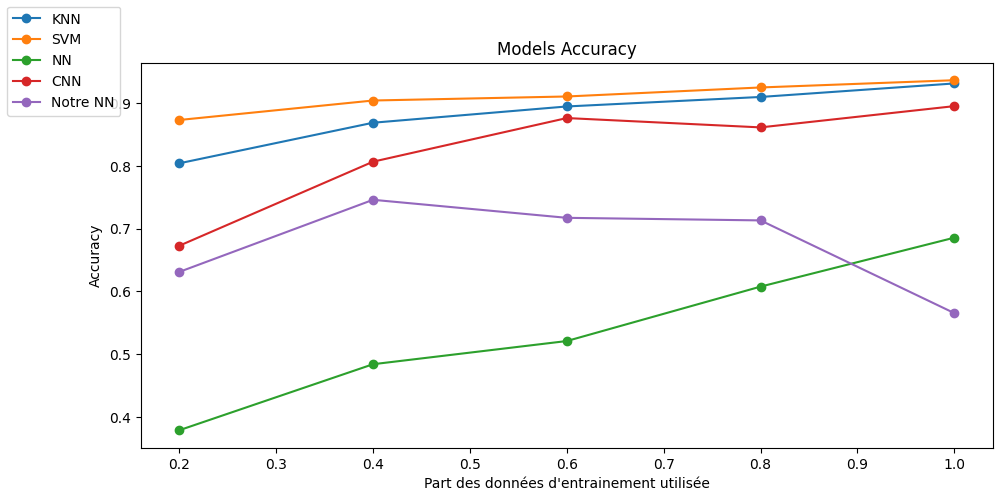

In [201]:
accuracy_knn_array = [accuracy_knn, accuracy_knn_80, accuracy_knn_60, accuracy_knn_40, accuracy_knn_20]
accuracy_svm_array = [accuracy_svm, accuracy_svm_80, accuracy_svm_60, accuracy_svm_40, accuracy_svm_20]
accuracy_nn_array = [accuracy_nn, accuracy_nn_80, accuracy_nn_60, accuracy_nn_40, accuracy_nn_20]
accuracy_cnn_array = [accuracy_cnn, accuracy_cnn_80, accuracy_cnn_60, accuracy_cnn_40, accuracy_cnn_20]
accuracy_my_nn_array = [accuracy_my_nn, accuracy_my_nn_80, accuracy_my_nn_60, accuracy_my_nn_40, accuracy_my_nn_20]
percents_array = [1,0.8,0.6,0.4,0.2]

fig_accuracy = plt.figure(figsize=(11,5))

plt.plot(percents_array, accuracy_knn_array, marker='o', label='KNN')
plt.plot(percents_array, accuracy_svm_array, marker='o', label='SVM')
plt.plot(percents_array, accuracy_nn_array, marker='o', label='NN')
plt.plot(percents_array, accuracy_cnn_array, marker='o', label='CNN')
plt.plot(percents_array, accuracy_my_nn_array, marker='o', label='Notre NN')

plt.title('Models Accuracy')
plt.xlabel('Part des données d\'entrainement utilisée')
plt.ylabel('Accuracy')
fig_accuracy.legend(loc="upper left")
plt.show(fig_accuracy)

Ce graphique permet d'évaluer en un coup d'oeil tous les modèles et de voir leur scalabilité.  
On voit les résultats sont variables avec certains modèles comme le NN qui sont beaucoup moins performants avec moins de données d'entrainement alors que certains modèles n'ont que peu de variations et que d'autres comme le notre ont même de meilleurs résultats lorsqu'il y a moins de données.  
  
Cete évolution étonnante peut s'expliquer par le fait que les données sont très simillaires, ce qui peut engendrer du sur-entrainement si le modèle est trop complexe.

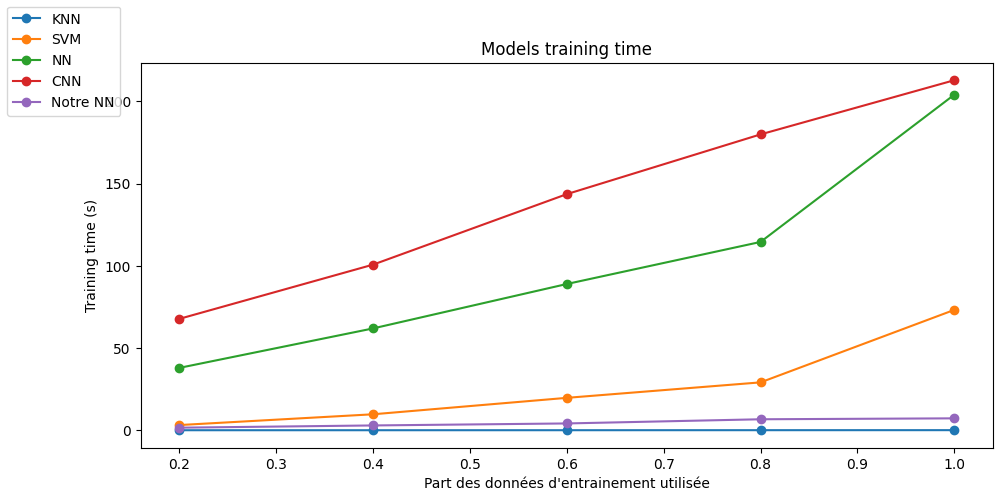

In [204]:
training_time_knn_array = [training_time_knn, training_time_knn_80, training_time_knn_60, training_time_knn_40, training_time_knn_20]
training_time_svm_array = [training_time_svm, training_time_svm_80, training_time_svm_60, training_time_svm_40, training_time_svm_20]
training_time_nn_array = [training_time_nn, training_time_nn_80, training_time_nn_60, training_time_nn_40, training_time_nn_20]
training_time_cnn_array = [training_time_cnn, training_time_cnn_80, training_time_cnn_60, training_time_cnn_40, training_time_cnn_20]
training_time_my_nn_array = [training_time_my_nn, training_time_my_nn_80, training_time_my_nn_60, training_time_my_nn_40, training_time_my_nn_20]
percents_array = [1,0.8,0.6,0.4,0.2]

fig_training_time = plt.figure(figsize=(11,5))

plt.plot(percents_array, training_time_knn_array, marker='o', label='KNN')
plt.plot(percents_array, training_time_svm_array, marker='o', label='SVM')
plt.plot(percents_array, training_time_nn_array, marker='o', label='NN')
plt.plot(percents_array, training_time_cnn_array, marker='o', label='CNN')
plt.plot(percents_array, training_time_my_nn_array, marker='o', label='Notre NN')

plt.title('Models training time')
plt.xlabel('Part des données d\'entrainement utilisée')
plt.ylabel('Training time (s)')
fig_training_time.legend(loc="upper left")
plt.show(fig_training_time)

Concernant la durée d'entrainement. On remarque que quasiment tous les modèles mettent plus de temps à s'entrainer lorsqu'il y a plus de données d'entrainement.  
Seul le KNN possède une durée d'entrainement quasiment identique. La logique de l'algorithme explique cette différence.

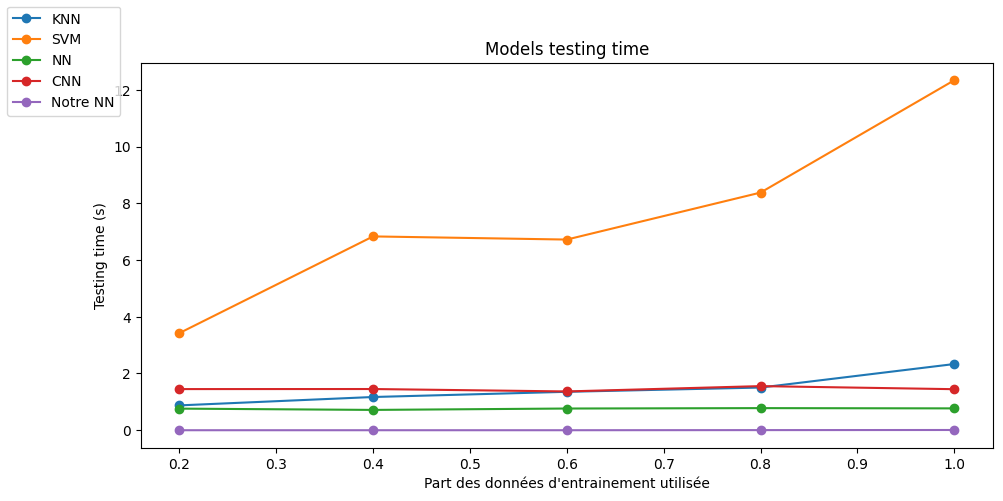

In [203]:
testing_time_knn_array = [testing_time_knn, testing_time_knn_80, testing_time_knn_60, testing_time_knn_40, testing_time_knn_20]
testing_time_svm_array = [testing_time_svm, testing_time_svm_80, testing_time_svm_60, testing_time_svm_40, testing_time_svm_20]
testing_time_nn_array = [testing_time_nn, testing_time_nn_80, testing_time_nn_60, testing_time_nn_40, testing_time_nn_20]
testing_time_cnn_array = [testing_time_cnn, testing_time_cnn_80, testing_time_cnn_60, testing_time_cnn_40, testing_time_cnn_20]
testing_time_my_nn_array = [testing_time_my_nn, testing_time_my_nn_80, testing_time_my_nn_60, testing_time_my_nn_40, testing_time_my_nn_20]
percents_array = [1,0.8,0.6,0.4,0.2]

fig_testing_time = plt.figure(figsize=(11,5))

plt.plot(percents_array, testing_time_knn_array, marker='o', label='KNN')
plt.plot(percents_array, testing_time_svm_array, marker='o', label='SVM')
plt.plot(percents_array, testing_time_nn_array, marker='o', label='NN')
plt.plot(percents_array, testing_time_cnn_array, marker='o', label='CNN')
plt.plot(percents_array, testing_time_my_nn_array, marker='o', label='Notre NN')

plt.title('Models testing time')
plt.xlabel('Part des données d\'entrainement utilisée')
plt.ylabel('Testing time (s)')
fig_testing_time.legend(loc="upper left")
plt.show(fig_testing_time)

Enfin, concernant la durée de test, elle ne varie que très peu pour tous les modèles sauf le SVM pour qui elle réalise une grande variation.  
On note néammoins le KNN qui a sa durée de test qui augmente aussi avec le nombre de données.  
  
Evidemment, pour les autres qui sont des modèles de réseaux de neurones, la compléxité est dans l'entrainement et non le test, ce qui explique l'évolution quasiment nulle du temps de test.

**Conclusion**  
  
Pour conclure, après avoir fait de nombreux traitements, tester des paramètres et comparer les résultats de notre réseau de neurones avec ceux implémentés dans des librairies, nous voyons que l'important n'est pas tant le réseau de neurones utilisé mais surtout le choix et le nettoyage des données ainsi que le choix des hyper-paramètres. Un algorithme est adapté à une situation spécifique et c'est à nous de choisir lequel utiliser en fonction de la situation.